## **LOAD LIBRARIES**

In [ ]:
!pip install pyLDAvis

In [ ]:
!pip install bertopic

In [ ]:
!pip install nrclex

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import pandas as pd
from IPython.display import display
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap

import re
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import pyLDAvis
# # import pyLDAvis.sklearn
# import pyLDAvis.display

import gensim
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models as gensimvis

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from sklearn.feature_extraction import text

from umap import UMAP
import plotly.io as pio
from collections import defaultdict


from sklearn.decomposition import NMF
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [ ]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from collections import Counter

In [ ]:
# Required imports for BERTopic
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction
from hdbscan import HDBSCAN

/usr/local/lib/python3.11/dist-packages/hdbscan/plots.py:448: DeprecationWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.11/dist-packages/hdbscan/robust_single_linkage_.py:154: DeprecationWarning: invalid escape sequence '\{'
  """Perform robust single linkage clustering from a vector array
/usr/local/lib/python3.11/dist-packages/geopandas/_compat.py:7: DeprecationWarning: The 'shapely.geos' module is deprecated, and will be removed in a future version. All attributes of 'shapely.geos' are available directly from the top-level 'shapely' namespace (since shapely 2.0.0).
  import shapely.geos


In [ ]:
from nrclex import NRCLex

## **LOAD DATA**

In [ ]:
file_url = "/content/drive/MyDrive/Cowry_Assignment/CDS_25_Task2.xlsx"
df1 = pd.read_excel(file_url, sheet_name="C Control")
df2 = pd.read_excel(file_url, sheet_name="C Pilot")

## **DATA REPORT**

In [ ]:
def classify_feature(series):
    """Intelligently classify feature types with coercion only when appropriate."""
    # Check for datetime
    if pd.api.types.is_datetime64_any_dtype(series):
        return 'Datetime'

    # Get number of unique non-null values
    n_unique = series.nunique(dropna=True)

    # Raw dtype
    dtype = series.dtype

    # Case 1: If it's already numeric dtype
    if pd.api.types.is_numeric_dtype(series):
        if n_unique == 2:
            return 'Binary (Numeric)'
        elif n_unique < 15:
            return 'Multiclass (Numeric)'
        else:
            return 'Numerical'

    # Case 2: If it's an object or string dtype, check if it can be converted
    elif dtype == 'object' or dtype.name == 'string':
        # Try converting to numeric
        coerced = pd.to_numeric(series, errors='coerce')
        non_na = coerced.notna().sum()
        ratio_numeric = non_na / len(series)

        # If most values (e.g. 90%+) are numeric-looking, treat as numeric
        if ratio_numeric > 0.9:
            if coerced.nunique(dropna=True) == 2:
                return 'Binary (Numeric)'
            elif coerced.nunique(dropna=True) < 15:
                return 'Multiclass (Numeric)'
            else:
                return 'Numerical'

        # Otherwise, treat as categorical
        if n_unique == 2:
            return 'Binary (Categorical)'
        elif n_unique < 15:
            return 'Categorical'
        else:
            return 'High Cardinality Categorical'

    # Default fallback
    else:
        return 'Unknown'


def summarize_feature(series):
    """Generate a summary of key values in the feature."""
    if pd.api.types.is_numeric_dtype(series):
        return f"Mean: {series.mean():.2f}, Median: {series.median():.2f}, Std: {series.std():.2f}"
    elif pd.api.types.is_datetime64_any_dtype(series):
        return f"Min: {series.min()}, Max: {series.max()}"
    else:
        top_categories = series.value_counts(dropna=True).head(3)
        return ', '.join(f"{repr(cat)} ({cnt})" for cat, cnt in top_categories.items())

def generate_enhanced_data_report(df):
    # --------- Dataset Summary ---------
    summary = {
        'Total Rows': df.shape[0],
        'Total Features': df.shape[1],
        'Features with Missing Values': df.isnull().any().sum(),
        'Rows with Missing Values': df.isnull().any(axis=1).sum(),
        'Total Missing Values': df.isnull().sum().sum(),
        'Duplicate Rows': df.duplicated().sum()
    }
    summary_df = pd.DataFrame.from_dict(summary, orient='index', columns=['Value'])

    # --------- Feature Report ---------
    report_rows = []

    for col in df.columns:
        series = df[col]
        feature_type = classify_feature(series)
        total = len(series)
        missing = series.isnull().sum()
        percent_missing = 100 * missing / total
        n_unique = series.nunique(dropna=True)
        example_values = series.dropna().unique()[:3]

        report_rows.append({
            'Feature': col,
            'Feature Type': feature_type,
            'Data Type':series.dtypes,
            '# Missing': missing,
            '% Missing': f"{percent_missing:.1f}%",
            '# Unique': n_unique,
            'Example Values': ', '.join(map(str, example_values)),
            'Summary Stats': summarize_feature(series)
        })

    feature_report_df = pd.DataFrame(report_rows)

    return summary_df, feature_report_df

In [ ]:
summary, feature_report = generate_enhanced_data_report(df1)
print('Summary of Data',summary)
display(feature_report)

Summary of Data                               Value
Total Rows                      380
Total Features                   13
Features with Missing Values      9
Rows with Missing Values        295
Total Missing Values            523
Duplicate Rows                    0


,Feature,Feature Type,Data Type,# Missing,% Missing,# Unique,Example Values,Summary Stats
0,COLUMN_4,Categorical,object,0,0.0%,1,control,'control' (380)
1,VOLT_FLAG,Categorical,object,191,50.3%,1,yes,'yes' (189)
2,SURVEY_ID,Numerical,int64,0,0.0%,380,"351124494, 351727144, 351645749","Mean: 355450085.76, Median: 355213099.00, Std:..."
3,SCORE,Multiclass (Numeric),int64,0,0.0%,11,"10, 0, 7","Mean: 8.12, Median: 10.00, Std: 3.09"
4,LTR_COMMENT,High Cardinality Categorical,object,94,24.7%,283,Conservations with your staff over the phone w...,"'Excellent service' (2), 'You keep sending me ..."
5,PRIMARY_REASON,High Cardinality Categorical,object,166,43.7%,95,"Customer Service,Installation,Processes/Journe...","'Customer Service,General,UK Legacy' (48), 'Ge..."
6,TO_CHAR,Datetime,datetime64[ns],0,0.0%,5,"2023-02-01 00:00:00, 2023-03-01 00:00:00, 2023...","Min: 2023-02-01 00:00:00, Max: 2023-06-01 00:0..."
7,CONNECTION_TIME,Multiclass (Numeric),float64,7,1.8%,11,"10.0, 0.0, 8.0","Mean: 8.60, Median: 10.00, Std: 2.66"
8,SALES_PERSON_SAT,Multiclass (Numeric),float64,27,7.1%,11,"10.0, 8.0, 5.0","Mean: 7.86, Median: 10.00, Std: 3.06"
9,SALES_FRIENDLY_SAT,Multiclass (Numeric),float64,14,3.7%,10,"10.0, 5.0, 0.0","Mean: 8.13, Median: 10.00, Std: 2.85"


In [ ]:
summary, feature_report = generate_enhanced_data_report(df2)
print('Summary of Data',summary)
display(feature_report)

Summary of Data                               Value
Total Rows                      267
Total Features                   13
Features with Missing Values      9
Rows with Missing Values        221
Total Missing Values            464
Duplicate Rows                    0


,Feature,Feature Type,Data Type,# Missing,% Missing,# Unique,Example Values,Summary Stats
0,COLUMN_4,Categorical,object,0,0.0%,1,pilot,'pilot' (267)
1,VOLT_FLAG,Categorical,object,177,66.3%,1,yes,'yes' (90)
2,SURVEY_ID,Numerical,object,0,0.0%,267,"351106184, 351657780, 351677562","351106184 (1), '35742company78' (1), 356118986..."
3,SCORE,Multiclass (Numeric),int64,0,0.0%,11,"10, 1, 0","Mean: 8.22, Median: 10.00, Std: 3.03"
4,LTR_COMMENT,High Cardinality Categorical,object,71,26.6%,190,"Very helpful, Excellent customer service very ...","'Very helpful' (4), 'Good service' (2), 'Excel..."
5,PRIMARY_REASON,High Cardinality Categorical,object,120,44.9%,79,"Customer Service,General,UK Legacy, Customer S...","'Customer Service,General,UK Legacy' (24), 'Cu..."
6,TO_CHAR,Categorical,object,0,0.0%,5,"2023-02-01 00:00:00, 01/03/2company3, 01/04/2c...","'01/03/2company3' (100), '01/04/2company3' (80..."
7,CONNECTION_TIME,Multiclass (Numeric),float64,13,4.9%,11,"10.0, 6.0, 4.0","Mean: 8.50, Median: 10.00, Std: 2.74"
8,SALES_PERSON_SAT,Multiclass (Numeric),float64,28,10.5%,9,"10.0, 1.0, 6.0","Mean: 7.92, Median: 9.00, Std: 3.04"
9,SALES_FRIENDLY_SAT,Multiclass (Numeric),float64,16,6.0%,11,"10.0, 8.0, 3.0","Mean: 8.15, Median: 10.00, Std: 2.85"


## **PREPROCESS**

As seen in data report we do have a lot of NULL values. So lets work on that

In [ ]:
#------------------------------------------------------------------
# REMOVE OR REPLACE NA VALUES
#------------------------------------------------------------------

# Columns to fill with mode
mode_cols = [
    'CONNECTION_TIME', 'SALES_PERSON_SAT',
    'SALES_FRIENDLY_SAT', 'COMMINICATION_SAT',
    'FIRST_BILL_SAT', 'AGENT_KNOWLEDGE'
  ]

def replace_na(df):
  # Fill missing values
  df['VOLT_FLAG'] = df['VOLT_FLAG'].fillna('No')
  df['LTR_COMMENT'] = df['LTR_COMMENT'].fillna('')
  df['PRIMARY_REASON'] = df['PRIMARY_REASON'].fillna('Reason not mentioned')

  for col in mode_cols:
    mode_value = df[col].mode()[0]
    df[col] = df[col].fillna(mode_value)

  Y = df1.isnull().any()
  print('DOES ANY COLUMN STILL HAVE NA? \n',Y,'\n')

  return df

In [ ]:
df1 = replace_na(df1)
df2 = replace_na(df2)

DOES ANY COLUMN STILL HAVE NA? 
 COLUMN_4              False
VOLT_FLAG             False
SURVEY_ID             False
SCORE                 False
LTR_COMMENT           False
PRIMARY_REASON        False
TO_CHAR               False
CONNECTION_TIME       False
SALES_PERSON_SAT      False
SALES_FRIENDLY_SAT    False
COMMINICATION_SAT     False
FIRST_BILL_SAT        False
AGENT_KNOWLEDGE       False
dtype: bool 

DOES ANY COLUMN STILL HAVE NA? 
 COLUMN_4              False
VOLT_FLAG             False
SURVEY_ID             False
SCORE                 False
LTR_COMMENT           False
PRIMARY_REASON        False
TO_CHAR               False
CONNECTION_TIME       False
SALES_PERSON_SAT      False
SALES_FRIENDLY_SAT    False
COMMINICATION_SAT     False
FIRST_BILL_SAT        False
AGENT_KNOWLEDGE       False
dtype: bool 



In [ ]:
#------------------------------------------------------------------
# FIX THE DATE COLUMN
#------------------------------------------------------------------

def parse_date_flexibly(date_str):
    for fmt in ("%Y-%m-%d %H:%M:%S", "%d/%m/%y"):
        try:
            return datetime.strptime(date_str, fmt)
        except ValueError:
            continue
    return pd.NaT  # if none of the formats work

def fix_date_col(df, col='TO_CHAR'):
    # If already datetime, skip conversion..like in the case of df1
    if pd.api.types.is_datetime64_any_dtype(df[col]):
        print(f"{col} is already datetime. Skipping conversion.")
        # Exclude any responses from February
        df = df[df[col].dt.month != 2]
        return df

    print(f"{col} is not datetime. Attempting conversion...")
    print(f"Unique values right now: {df[col].unique()}")

    # Convert all to string in case of mixed types
    df[col] = df[col].astype(str)

    # Remove 'company' text...which is there in df2
    df[col] = df[col].str.replace('company', '', regex=False)

    df[col] = df[col].apply(parse_date_flexibly)

    print(f"Unique values right now: {df[col].unique()}, Shape of dataframe : {df.shape}")

    # Exclude any responses from February
    df = df[df[col].dt.month != 2]

    print(f"Unique values right now: {df[col].unique()}, Shape of dataframe : {df.shape}")

    return df

In [ ]:
df1 = fix_date_col(df1)
df2 = fix_date_col(df2)

TO_CHAR is already datetime. Skipping conversion.
TO_CHAR is not datetime. Attempting conversion...
Unique values right now: [datetime.datetime(2023, 2, 1, 0, 0) '01/03/2company3' '01/04/2company3'
 '01/05/2company3' '01/06/2company3']
Unique values right now: <DatetimeArray>
['2023-02-01 00:00:00', '2023-03-01 00:00:00', '2023-04-01 00:00:00',
 '2023-05-01 00:00:00', '2023-06-01 00:00:00']
Length: 5, dtype: datetime64[ns], Shape of dataframe : (267, 13)
Unique values right now: <DatetimeArray>
['2023-03-01 00:00:00', '2023-04-01 00:00:00', '2023-05-01 00:00:00',
 '2023-06-01 00:00:00']
Length: 4, dtype: datetime64[ns], Shape of dataframe : (247, 13)


## **SEGMENT DATA**

In [ ]:
# Combine datasets....might be required later
df_all = pd.concat([df1, df2], ignore_index=True)
df_all.shape

(582, 13)

In [ ]:
# Combine all segments for plotting
df_all['segment'] = df_all.apply(
    lambda row: f"{'volt' if row['VOLT_FLAG'] == 'yes' else 'nonvolt'}_{row['COLUMN_4']}", axis=1)

In [ ]:
df_all['segment'].value_counts()

,count
segment,
nonvolt_control,177
nonvolt_pilot,164
volt_control,158
volt_pilot,83


## **PROCESS LTR_COMMENT**

In [ ]:
#------------------------------------------------------------------
# LIGHTEIGHT CLEANING
#------------------------------------------------------------------

def preprocess_text(text):
    print("\n--- ORIGINAL TEXT ---")
    print(text)

    # Lowercase
    text = text.lower()
    print("\n[1] Lowercased:")
    print(text)

    # Remove punctuation (but keep sentence boundaries if needed)
    text = re.sub(r"[^\w\s\.]", "", text)
    print("\n[2] Removed unwanted punctuation:")
    print(text)

    # Clean extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    print("\n[3] Final cleaned text:")
    print(text)

    return text


In [ ]:
test_text = "The young man who helped me was *extremely* polite, but  8 I did not understand the offer."
print(preprocess_text(test_text))


--- ORIGINAL TEXT ---
The young man who helped me was *extremely* polite, but  8 I did not understand the offer.

[1] Lowercased:
the young man who helped me was *extremely* polite, but  8 i did not understand the offer.

[2] Removed unwanted punctuation:
the young man who helped me was extremely polite but  8 i did not understand the offer.

[3] Final cleaned text:
the young man who helped me was extremely polite but 8 i did not understand the offer.
the young man who helped me was extremely polite but 8 i did not understand the offer.


In [ ]:
df_all['LTR_COMMENT_CLEAN'] = df_all['LTR_COMMENT'].apply(preprocess_text)


--- ORIGINAL TEXT ---
Good package

[1] Lowercased:
good package

[2] Removed unwanted punctuation:
good package

[3] Final cleaned text:
good package

--- ORIGINAL TEXT ---
Very good customer service

[1] Lowercased:
very good customer service

[2] Removed unwanted punctuation:
very good customer service

[3] Final cleaned text:
very good customer service

--- ORIGINAL TEXT ---
So far so good. Charlie was very efficient and helpful. Let¬"s hope it continues so. I am confident it will

[1] Lowercased:
so far so good. charlie was very efficient and helpful. let¬"s hope it continues so. i am confident it will

[2] Removed unwanted punctuation:
so far so good. charlie was very efficient and helpful. lets hope it continues so. i am confident it will

[3] Final cleaned text:
so far so good. charlie was very efficient and helpful. lets hope it continues so. i am confident it will

--- ORIGINAL TEXT ---
Great communication

[1] Lowercased:
great communication

[2] Removed unwanted punctuatio

In [ ]:
#------------------------------------------------------------------
# HEAVYWEIGHT PROCESSING
#------------------------------------------------------------------

# en_core_web_sm
# en_core_web_trf
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

def preprocess_for_topic_modelling(text):
    print("\n--- ORIGINAL TEXT ---")
    print(text)

    # 1. Lowercase
    text = text.lower()
    print("\n[1] Lowercased:")
    print(text)

    text = text.replace("can't say yet", "unsure")

    # Remove non-ASCII characters (e.g., garbled emojis, symbols)
    text = text.encode("ascii", "ignore").decode("ascii")

    # 2. Tokenize
    doc = nlp(text)
    print("\n[2] Tokenized:")
    print([token.text for token in doc])

    # 3. Lemmatize & remove stopwords (preserve negation)
    preserved_negations = {"not", "no", "never", "nt", "cant", "cannot"}
    lemmatized = [
        token.lemma_ for token in doc
        if (
            token.lemma_ in preserved_negations
            or (token.lemma_ not in STOP_WORDS and not token.is_space)
        )
        and len(token.lemma_) > 2
        and re.search(r"[a-zA-Z]", token.lemma_)  # <- REMOVE if no letters
    ]
    print("\n[3] Lemmatized & stopwords removed (negation preserved):")
    print(lemmatized)

    # 4. Remove punctuation from lemmatized tokens
    cleaned_tokens = [re.sub(r"[^\w\s]", "", token) for token in lemmatized if re.sub(r"[^\w\s]", "", token)]

    # Remove any token that contains non-ASCII characters
    final_tokens = [tok for tok in cleaned_tokens if tok.isascii() and tok.isalpha()]

    print("\n[4] After punctuation removal:")
    print(final_tokens)

    # 5. Final cleaned string
    cleaned_text = " ".join(final_tokens)
    print("\n[5] Final cleaned for topic modelling:")
    print(cleaned_text)

    return cleaned_text

In [ ]:
test_text = "The young man who helped me was *extremely* polite, but I did not understand the offer so i would rate 4."
print(preprocess_for_topic_modelling(test_text))


--- ORIGINAL TEXT ---
The young man who helped me was *extremely* polite, but I did not understand the offer so i would rate 4.

[1] Lowercased:
the young man who helped me was *extremely* polite, but i did not understand the offer so i would rate 4.

[2] Tokenized:
['the', 'young', 'man', 'who', 'helped', 'me', 'was', '*', 'extremely', '*', 'polite', ',', 'but', 'i', 'did', 'not', 'understand', 'the', 'offer', 'so', 'i', 'would', 'rate', '4', '.']

[3] Lemmatized & stopwords removed (negation preserved):
['young', 'man', 'help', 'extremely', 'polite', 'not', 'understand', 'offer', 'rate']

[4] After punctuation removal:
['young', 'man', 'help', 'extremely', 'polite', 'not', 'understand', 'offer', 'rate']

[5] Final cleaned for topic modelling:
young man help extremely polite not understand offer rate
young man help extremely polite not understand offer rate


In [ ]:

test_text = "The engineer Steve was on time friendly and helpful ðx_x0018_"
print(preprocess_for_topic_modelling(test_text))


--- ORIGINAL TEXT ---
The engineer Steve was on time friendly and helpful ðx_x0018_

[1] Lowercased:
the engineer steve was on time friendly and helpful ðx_x0018_

[2] Tokenized:
['the', 'engineer', 'steve', 'was', 'on', 'time', 'friendly', 'and', 'helpful', 'x_x0018', '_']

[3] Lemmatized & stopwords removed (negation preserved):
['engineer', 'steve', 'time', 'friendly', 'helpful', 'x_x0018']

[4] After punctuation removal:
['engineer', 'steve', 'time', 'friendly', 'helpful']

[5] Final cleaned for topic modelling:
engineer steve time friendly helpful
engineer steve time friendly helpful


In [ ]:
df_all['LTR_COMMENT_TOPIC_M'] = df_all['LTR_COMMENT'].apply(preprocess_for_topic_modelling)

Streaming output truncated to the last 5000 lines.
[1] Lowercased:


[2] Tokenized:
[]

[3] Lemmatized & stopwords removed (negation preserved):
[]

[4] After punctuation removal:
[]

[5] Final cleaned for topic modelling:


--- ORIGINAL TEXT ---
Good customer service, polite Staff

[1] Lowercased:
good customer service, polite staff

[2] Tokenized:
['good', 'customer', 'service', ',', 'polite', 'staff']

[3] Lemmatized & stopwords removed (negation preserved):
['good', 'customer', 'service', 'polite', 'staff']

[4] After punctuation removal:
['good', 'customer', 'service', 'polite', 'staff']

[5] Final cleaned for topic modelling:
good customer service polite staff

--- ORIGINAL TEXT ---
Your lady who helped me, her name was Clara, was absolutely wonder. She explained everything to me, and was a delight to speak to.please thank her for me, and tell her I enjoyed our chat.

[1] Lowercased:
your lady who helped me, her name was clara, was absolutely wonder. she explained everything to m

## **LDA**

In [ ]:
df_all = df_all.drop_duplicates(subset='LTR_COMMENT_TOPIC_M')

In [ ]:
len(df_all)

395

In [ ]:
df_all['LTR_COMMENT_TOPIC_M']

,LTR_COMMENT_TOPIC_M
0,good package
1,good customer service
2,far good charlie efficient helpful lets hope c...
3,great communication
4,chris amazing contact detail online
...,...
576,new company medium unsure like service set acc...
577,efficient
578,helpful informative
579,gentleman deal helpful friendly deserve lot cr...


In [ ]:
df_all = df_all[df_all['LTR_COMMENT_TOPIC_M'].str.split().str.len() > 1]

📊 Vectorizing already-cleaned text...
🧠 Fitting LDA with 5 topics...

🔠 Top keywords per topic:
Topic 1: man | request | contact | communication | problem | experience | broadband | installation | internet | work
Topic 2: box | try | extremely | sort | install | come | time | great | medium | engineer
Topic 3: need | great | patient | professional | know | explain | deal | excellent | process | polite
Topic 4: great | contract | happy | email | job | understand | order | charge | package | price
Topic 5: understand | price | cancel | lady | thing | time | explain | nice | quick | efficient

🌥 Generating word clouds...


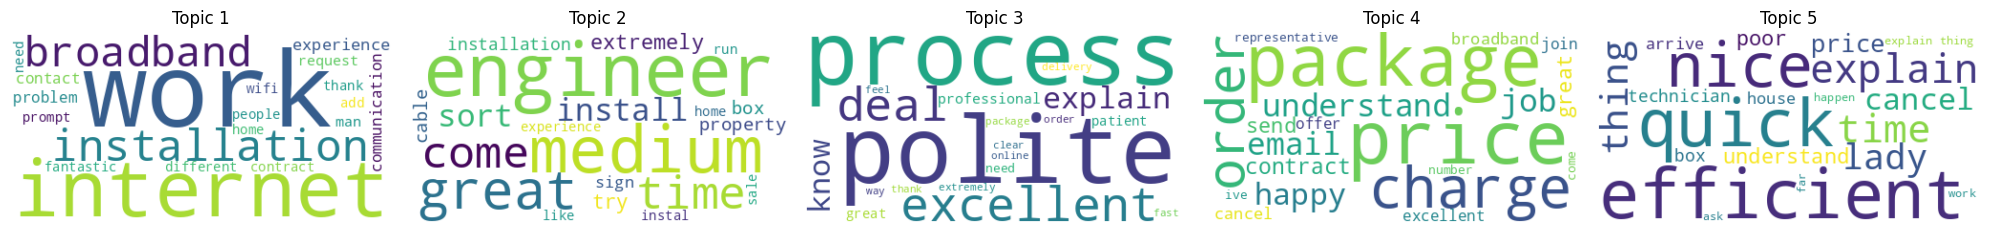


📊 Calculating topic proportions per treatment group...


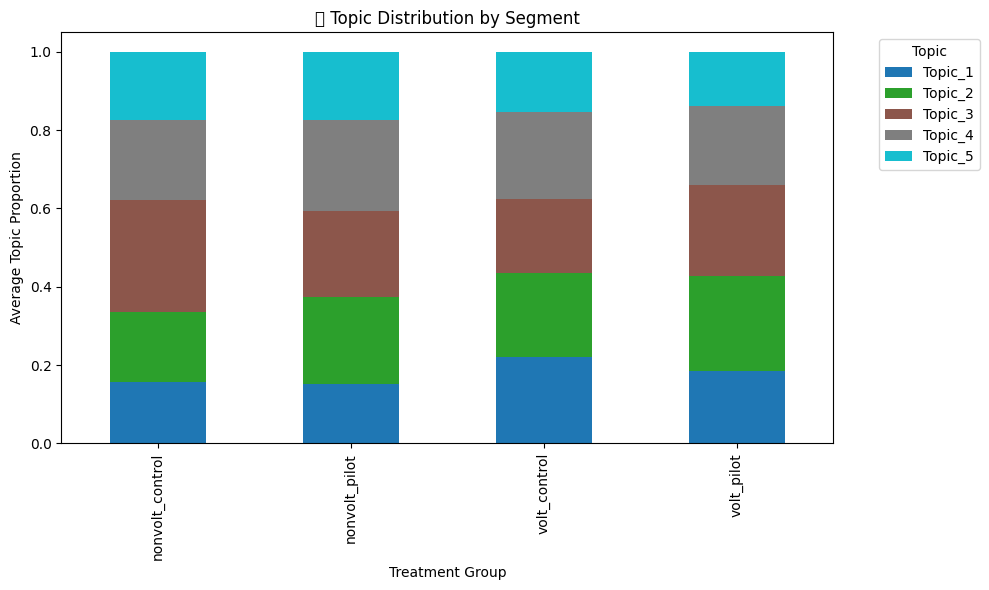

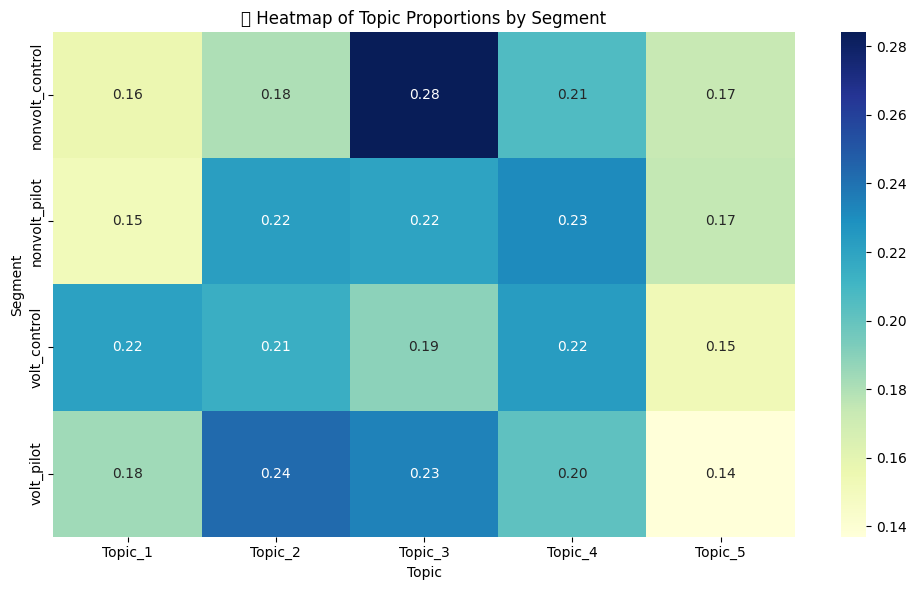

In [ ]:

def run_topic_modeling_on_clean_text(df, text_column, n_topics=5, max_features=5000):
    print("📊 Vectorizing already-cleaned text...")

     # Add domain-specific stop words
    custom_stopwords = [
        "company", "customer", "support", "team", "agent", "staff",
        "help", "rep", "call", "phone", "user", "client","day","new","sky","want","use","tell","service","friendly","april","easy","good","speak","set","helpful"
    ]
    full_stopwords = text.ENGLISH_STOP_WORDS.union(custom_stopwords)

    vectorizer = CountVectorizer(max_df=0.7, min_df=3, max_features=max_features,stop_words=list(full_stopwords),ngram_range=(1, 2))
    dtm = vectorizer.fit_transform(df[text_column].dropna())

    print(f"🧠 Fitting LDA with {n_topics} topics...")
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(dtm)

    # Show top keywords for each topic
    print("\n🔠 Top keywords per topic:")
    for i, topic in enumerate(lda.components_):
        words = [vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]]
        print(f"Topic {i + 1}: {' | '.join(words)}")

    # Word clouds
    print("\n🌥 Generating word clouds...")
    fig, axs = plt.subplots(1, n_topics, figsize=(4 * n_topics, 4))
    for i, topic in enumerate(lda.components_):
        word_freq = {vectorizer.get_feature_names_out()[j]: topic[j] for j in topic.argsort()[-20:]}
        wordcloud = WordCloud(background_color="white").generate_from_frequencies(word_freq)
        axs[i].imshow(wordcloud, interpolation="bilinear")
        axs[i].axis("off")
        axs[i].set_title(f"Topic {i + 1}")
    plt.tight_layout()
    plt.show()

    # --- Topic Distribution by Segment ---
    print("\n📊 Calculating topic proportions per treatment group...")
    topic_distributions = lda.transform(dtm)
    topic_df = pd.DataFrame(topic_distributions, columns=[f"Topic_{i+1}" for i in range(n_topics)])
    topic_df["segment"] = df.loc[df[text_column].dropna().index, "segment"].values

    group_avg = topic_df.groupby("segment").mean()

    group_avg.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="tab10")
    plt.title("🧩 Topic Distribution by Segment")
    plt.ylabel("Average Topic Proportion")
    plt.xlabel("Treatment Group")
    plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    # 🔥 Optional: Heatmap for finer detail
    plt.figure(figsize=(10, 6))
    sns.heatmap(group_avg, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title("🔥 Heatmap of Topic Proportions by Segment")
    plt.ylabel("Segment")
    plt.xlabel("Topic")
    plt.tight_layout()
    plt.show()

    return lda, vectorizer
lda_model, vectorizer = run_topic_modeling_on_clean_text(df_all, 'LTR_COMMENT_TOPIC_M', n_topics=5)


Topic 1: Service quality feedback (great, excellent, efficient, friendly)

Topic 2: Time/pricing concerns with mixed sentiment

Topic 3: Professional staff interactions (helpful, polite, professional)

Topic 4: Process/setup experiences (package, deal, explain, easy)

Topic 5: Communication channels (broadband, phone, email, contract)

📊 Vectorizing already-cleaned text (with bigrams)...
🧠 Fitting LDA with 5 topics...

🔠 Top keywords per topic (with bigrams highlighted):
📌 Topic 1:
  🔗 good customer | customer care | explain need | service good | good package | far good | great customer | excellent customer | service excellent | customer service
📌 Topic 2:
  🔗 efficient service | great deal | reasonable price | service great | direct debit | explain process | great price | good customer | good price | great service
📌 Topic 3:
  🔗 easy talk | person speak | explain need | customer care | broadband package | come day | service company | polite professional | need know | engineer come
📌 Topic 4:
  🔗 come install | person speak | order phone | recommend company | work home | good communication | explain thing | easy set | excellent service | company medium
📌 Topic 5:
  🔗 set account | service engineer | new customer | try sort | sign new | difficult understand | lady speak | quick easy | happy service | good service

🌥 G

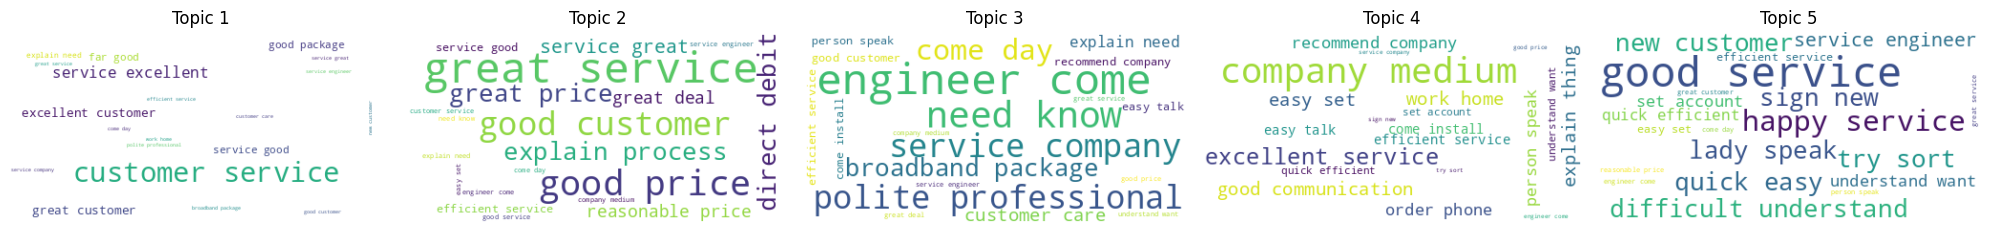


💬 Sample Comments per Topic:

🧵 Topic 1:
  • coz davie lovely great salesman local hope maintain excellent customer service previous customer company customer service absolutely pant
  • customer service excellent customer leave crawl haha
  • great customer service good wifi market like hear company engineer use white box wire install completion
  • team come friendly explain need clear fact trainee provide excellent customer service
  • register volt broadband plus sim receive pre contract css correct detail message buy plus landline hour phone customer service correct message let lock attach css contract correct entry different pre 

🧵 Topic 2:
  • great service good price
  • efficient service great price fast setup delivery great round
  • great service sale consultant great deal offer
  • great service friendly staff
  • great service phone brilliant package previous provider not match round satisfied

🧵 Topic 3:
  • helpful easy talk not pushy commit good deal willing free pate

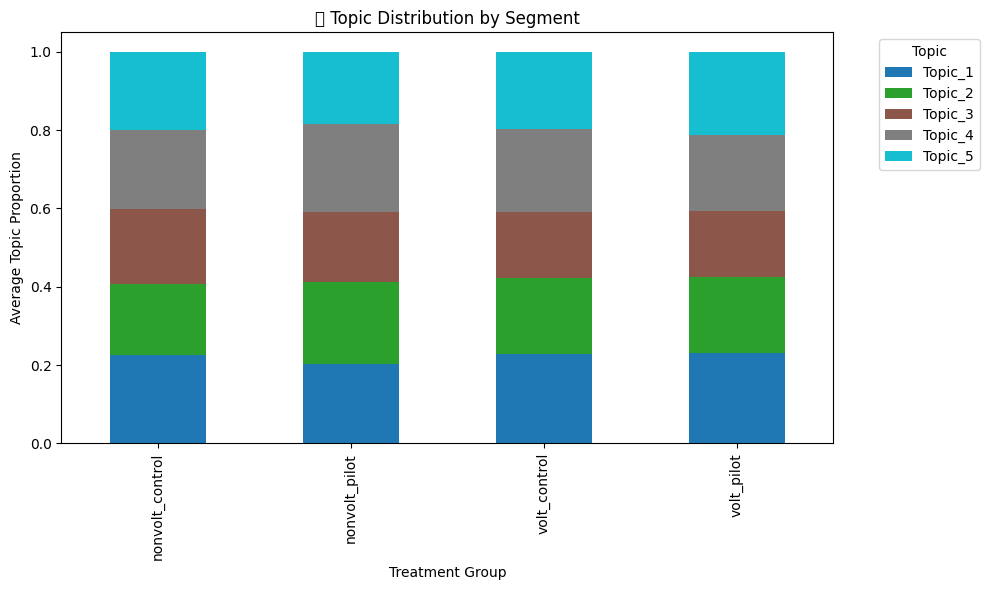

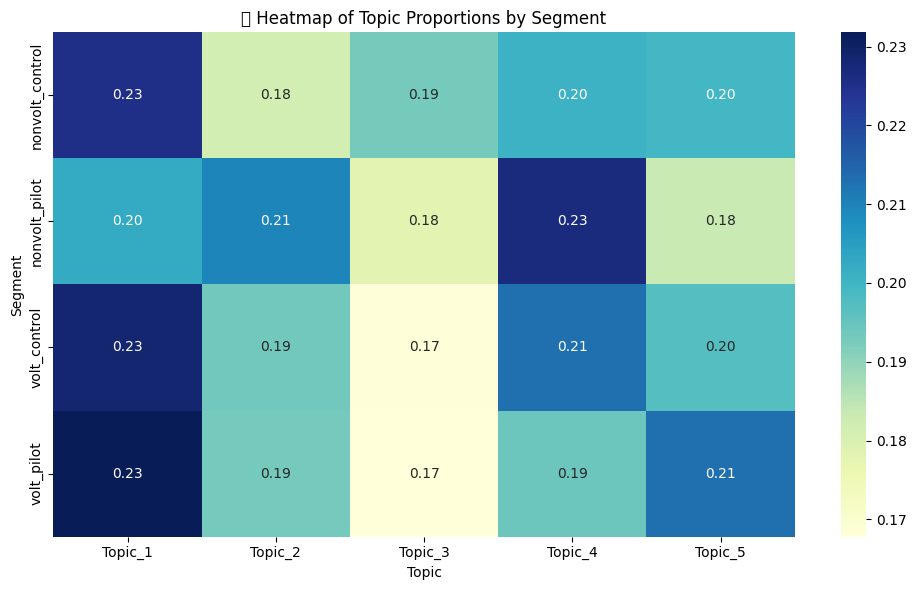

In [ ]:
def run_topic_modeling_on_clean_text(df, text_column, n_topics=5, max_features=5000):
    print("📊 Vectorizing already-cleaned text (with bigrams)...")

    # Add domain-specific stop words
    custom_stopwords = [
       "helpful","friendly"
    ]
    full_stopwords = text.ENGLISH_STOP_WORDS.union(custom_stopwords)

    # Vectorizer with bigrams
    vectorizer = CountVectorizer(
        stop_words=list(full_stopwords),
        max_df=0.7,
        min_df=3,
        max_features=max_features,
        ngram_range=(2, 2)
    )

    df_clean = df[text_column].dropna()
    dtm = vectorizer.fit_transform(df_clean)

    print(f"🧠 Fitting LDA with {n_topics} topics...")
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(dtm)

    # Show top bigrams per topic
    print("\n🔠 Top keywords per topic (with bigrams highlighted):")
    for i, topic in enumerate(lda.components_):
        words = [vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]]
        print(f"📌 Topic {i + 1}:\n  🔗 " + " | ".join(words))

    # Word clouds
    print("\n🌥 Generating word clouds...")
    fig, axs = plt.subplots(1, n_topics, figsize=(4 * n_topics, 4))
    for i, topic in enumerate(lda.components_):
        word_freq = {vectorizer.get_feature_names_out()[j]: topic[j] for j in topic.argsort()[-20:]}
        wordcloud = WordCloud(background_color="white").generate_from_frequencies(word_freq)
        axs[i].imshow(wordcloud, interpolation="bilinear")
        axs[i].axis("off")
        axs[i].set_title(f"Topic {i + 1}")
    plt.tight_layout()
    plt.show()

    # Sample Comments per Topic
    print("\n💬 Sample Comments per Topic:")
    topic_distributions = lda.transform(dtm)
    for topic_idx in range(n_topics):
        top_indices = topic_distributions[:, topic_idx].argsort()[-5:][::-1]
        print(f"\n🧵 Topic {topic_idx + 1}:")
        for idx in top_indices:
            print(f"  • {df_clean.iloc[idx][:200]}")  # Limiting comment length for readability

    # --- Topic Distribution by Segment ---
    print("\n📊 Calculating topic proportions per treatment group...")
    topic_distributions = lda.transform(dtm)
    topic_df = pd.DataFrame(topic_distributions, columns=[f"Topic_{i+1}" for i in range(n_topics)])
    topic_df["segment"] = df.loc[df[text_column].dropna().index, "segment"].values

    group_avg = topic_df.groupby("segment").mean()

    group_avg.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="tab10")
    plt.title("🧩 Topic Distribution by Segment")
    plt.ylabel("Average Topic Proportion")
    plt.xlabel("Treatment Group")
    plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    # 🔥 Optional: Heatmap for finer detail
    plt.figure(figsize=(10, 6))
    sns.heatmap(group_avg, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title("🔥 Heatmap of Topic Proportions by Segment")
    plt.ylabel("Segment")
    plt.xlabel("Topic")
    plt.tight_layout()
    plt.show()

    return lda, vectorizer

# Run updated function
lda_model, vectorizer = run_topic_modeling_on_clean_text(df_all, 'LTR_COMMENT_TOPIC_M', n_topics=5)

## **TFDIF**

In [ ]:
len(df_all)

395

📊 Vectorizing already-cleaned text (TF-IDF with unigrams & bigrams)...
🧠 Fitting NMF with 5 topics...

🔠 Top keywords per topic:
📌 Topic 1: good communication | internet | product | easy | service good | good price | service | price | good service | good
📌 Topic 2: friendly staff | easy | advisor | quick | efficient friendly | help | efficient | staff | friendly service | friendly
📌 Topic 3: happy | prompt | friendly service | quick | fantastic | good service | service excellent | excellent service | excellent | service
📌 Topic 4: work | tell | easy | day | process | explain | set | speak | polite | phone
📌 Topic 5: service engineer | great deal | super | great price | price | quick | engineer | service | great service | great

🌥 Generating word clouds...


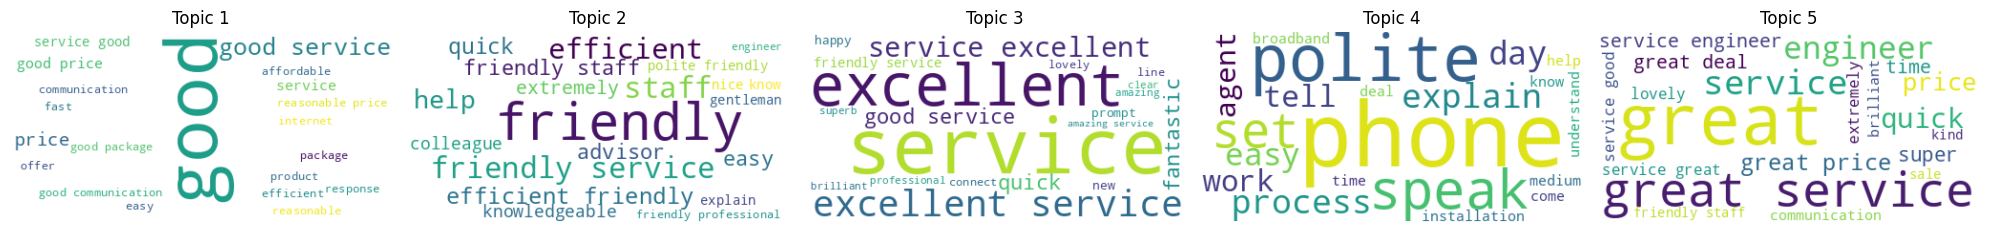


💬 Sample Comments per Topic:

🧵 Topic 1:
  • good never
  • alright reasonably good
  • good services
  • good customer service
  • good service

🧵 Topic 2:
  • friendly helpful
  • helpful friendly
  • adviser friendly helpful
  • friendly adviser
  • friendly experienced staff

🧵 Topic 3:
  • hood customer service
  • goo service
  • service fabulous
  • excellent service
  • excellent customer service

🧵 Topic 4:
  • agent come polite helpful tell phone box wire house quick set not allocate time stay solve problem explain work
  • polite helpful speak somebody
  • easy set process helpful staff phone
  • mat incredibly helpful friendly feel ease try decide pressure lay fact remain friendly engineer come speak cary incredibly helpful book day polite talkative finally come colleague unable install great
  • company everyday speak different people different department time explain situation member yes activate internet different department department not manager available talk tell ac

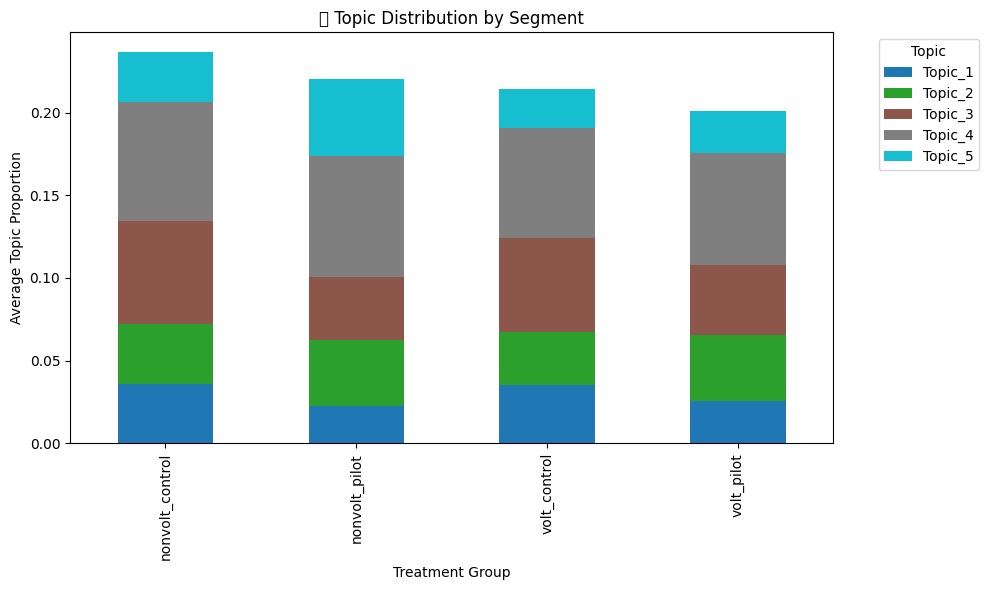

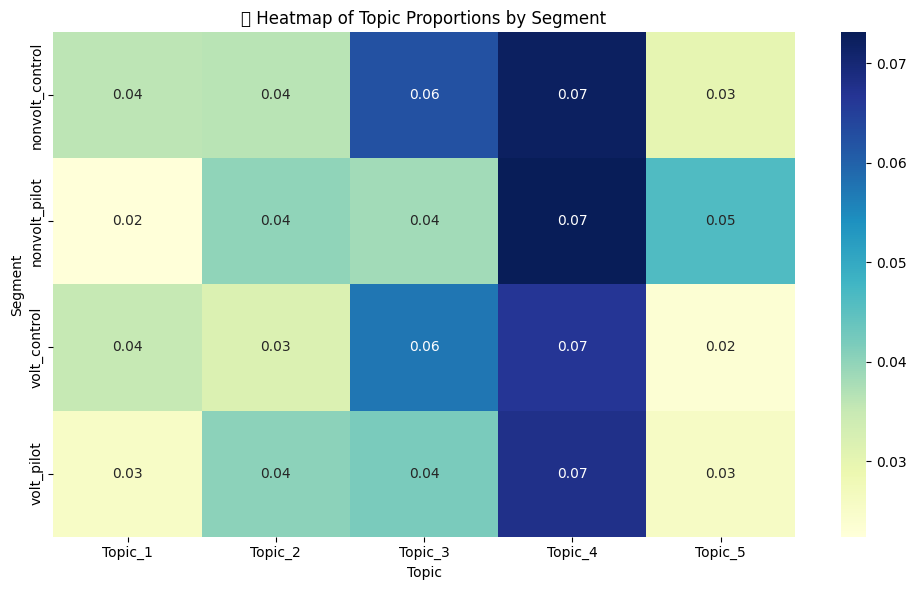

In [ ]:


def run_nmf_topic_modeling_on_clean_text(df, text_column, n_topics=5, max_features=5000):
    print("📊 Vectorizing already-cleaned text (TF-IDF with unigrams & bigrams)...")

    # Domain-specific stop words
    custom_stopwords = [
        "company", "customer","helpful","sky"
    ]
    full_stopwords = text.ENGLISH_STOP_WORDS.union(custom_stopwords)

    # TF-IDF vectorization with unigrams + bigrams
    vectorizer = TfidfVectorizer(
        stop_words=list(full_stopwords),
        max_df=0.7,
        min_df=3,
        max_features=max_features,
        ngram_range=(1, 2)
    )

    df_clean = df[text_column].dropna()
    tfidf = vectorizer.fit_transform(df_clean)

    print(f"🧠 Fitting NMF with {n_topics} topics...")
    nmf = NMF(n_components=n_topics, random_state=42)
    nmf.fit(tfidf)

    # Show top terms for each topic
    print("\n🔠 Top keywords per topic:")
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(nmf.components_):
        top_words = [feature_names[i] for i in topic.argsort()[-10:]]
        print(f"📌 Topic {topic_idx + 1}: {' | '.join(top_words)}")

    # Word clouds
    print("\n🌥 Generating word clouds...")
    fig, axs = plt.subplots(1, n_topics, figsize=(4 * n_topics, 4))
    for i, topic in enumerate(nmf.components_):
        word_freq = {feature_names[j]: topic[j] for j in topic.argsort()[-20:]}
        wordcloud = WordCloud(background_color="white").generate_from_frequencies(word_freq)
        axs[i].imshow(wordcloud, interpolation="bilinear")
        axs[i].axis("off")
        axs[i].set_title(f"Topic {i + 1}")
    plt.tight_layout()
    plt.show()

    # Show example comments per topic
    print("\n💬 Sample Comments per Topic:")
    topic_distributions = nmf.transform(tfidf)
    for topic_idx in range(n_topics):
        top_indices = topic_distributions[:, topic_idx].argsort()[-5:][::-1]
        print(f"\n🧵 Topic {topic_idx + 1}:")
        for idx in top_indices:
            print(f"  • {df_clean.iloc[idx][:200]}")

    # --- Topic Distribution by Segment ---
    print("\n📊 Calculating topic proportions per treatment group...")
    topic_distributions = nmf.transform(tfidf)
    topic_df = pd.DataFrame(topic_distributions, columns=[f"Topic_{i+1}" for i in range(n_topics)])
    topic_df["segment"] = df.loc[df[text_column].dropna().index, "segment"].values

    group_avg = topic_df.groupby("segment").mean()

    group_avg.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="tab10")
    plt.title("🧩 Topic Distribution by Segment")
    plt.ylabel("Average Topic Proportion")
    plt.xlabel("Treatment Group")
    plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    # 🔥 Optional: Heatmap for finer detail
    plt.figure(figsize=(10, 6))
    sns.heatmap(group_avg, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title("🔥 Heatmap of Topic Proportions by Segment")
    plt.ylabel("Segment")
    plt.xlabel("Topic")
    plt.tight_layout()
    plt.show()

    return nmf, vectorizer
nmf_model, tfidf_vectorizer = run_nmf_topic_modeling_on_clean_text(df_all, 'LTR_COMMENT_TOPIC_M', n_topics=5)

## **BERT**

2025-06-22 05:24:21,741 - BERTopic - Embedding - Transforming documents to embeddings.


📥 Extracting text data...
🔍 Configuring dimensionality reduction and clustering...
🧠 Initializing BERTopic...
🚀 Fitting BERTopic model...


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

2025-06-22 05:24:29,290 - BERTopic - Embedding - Completed ✓
2025-06-22 05:24:29,293 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-22 05:24:30,543 - BERTopic - Dimensionality - Completed ✓
2025-06-22 05:24:30,548 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-22 05:24:30,577 - BERTopic - Cluster - Completed ✓
2025-06-22 05:24:30,584 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-22 05:24:30,639 - BERTopic - Representation - Completed ✓


📊 Top topics:
   Topic  Count                                        Name  \
0     -1    129                    -1_order_agent_deal_sort   
1      0     78                   0_phone_broadband_day_new   
2      1     52             1_communication_speak_talk_lady   
3      2     42        2_engineer_installation_come_install   
4      3     35             3_staff_explain_advisor_patient   
5      4     30         4_excellent_fantastic_great_amazing   
6      5     15  5_quick_quick efficient_efficient_coverage   
7      6     14   6_price_reasonable price_reasonable_value   

                                      Representation  \
0  [order, agent, deal, sort, great, polite, easy...   
1  [phone, broadband, day, new, work, speak, inte...   
2  [communication, speak, talk, lady, thing, expl...   
3  [engineer, installation, come, install, engine...   
4  [staff, explain, advisor, patient, polite, ext...   
5  [excellent, fantastic, great, amazing, brillia...   
6  [quick, quick efficient

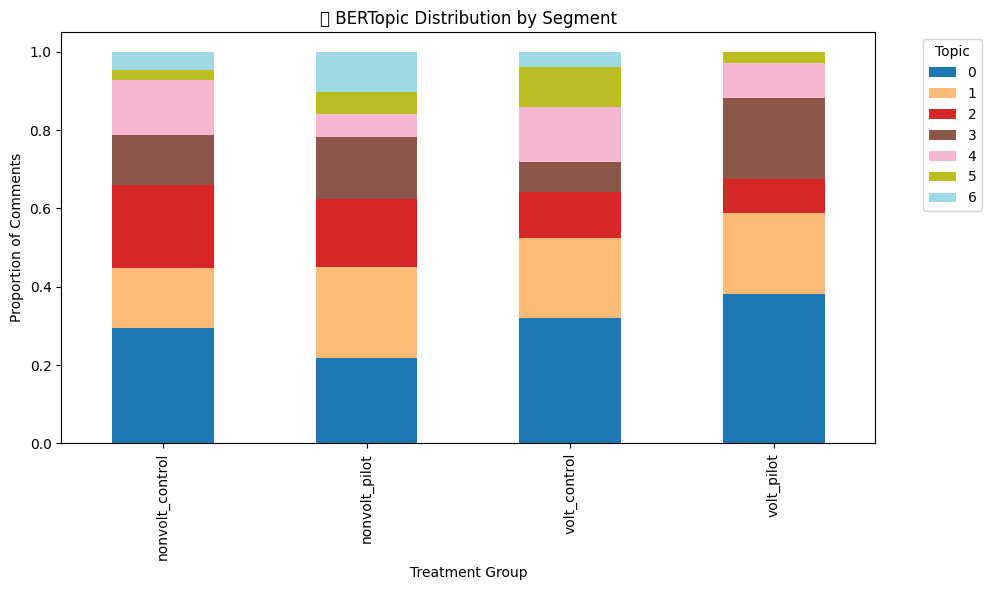

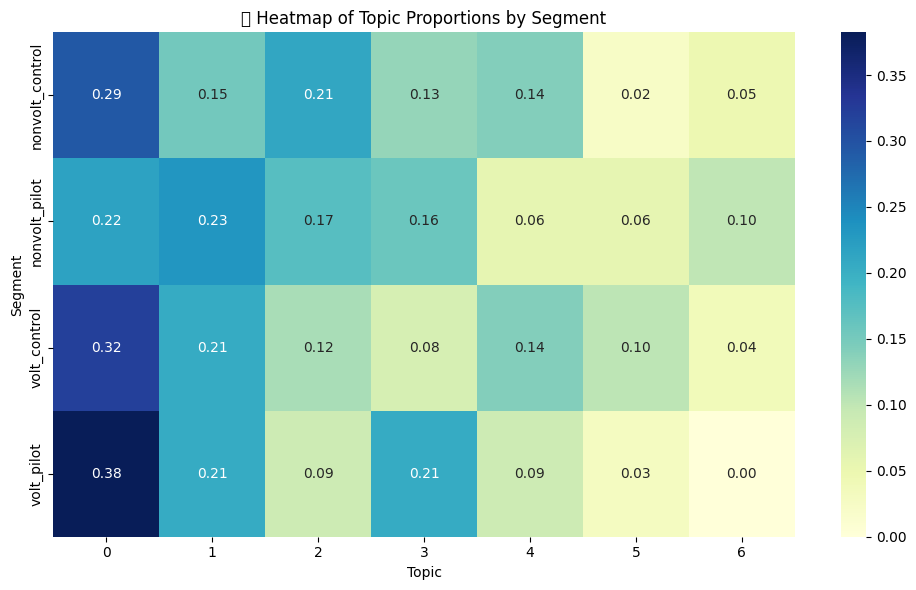

In [ ]:


def run_bertopic_modeling(df, text_column, n_neighbors=10, min_cluster_size=10, language_model="all-MiniLM-L6-v2"):

    print("📥 Extracting text data...")
    texts = df[text_column].dropna().tolist()

    print("🔍 Configuring dimensionality reduction and clustering...")
    umap_model = UMAP(n_neighbors=n_neighbors, n_components=5, min_dist=0.2, metric='cosine')
    hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size, metric='euclidean', prediction_data=True)


    # Base English stopwords
    default_stopwords = text.ENGLISH_STOP_WORDS

    # Custom domain-specific additions
    custom_stopwords = default_stopwords.union([
        "company","helpful","friendly","good","service","customer"
    ])


    print("🧠 Initializing BERTopic...")
    topic_model = BERTopic(
        embedding_model=language_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=CountVectorizer(ngram_range=(1, 2), stop_words=list(custom_stopwords)),
        verbose=True
    )

    print("🚀 Fitting BERTopic model...")
    topics, probs = topic_model.fit_transform(texts)

    print("📊 Top topics:")
    print(topic_model.get_topic_info().head(10))

    # print("🌍 Visualizing topic space...")
    # topic_model.visualize_topics().show()

    # --- NEW SECTION: Topic distribution per group ---
    print("\n📈 Calculating topic proportions per treatment group...")

    # Attach topics to DataFrame
    df_clean = df.copy()
    df_clean["topic"] = topics
    df_clean["segment"] = df.loc[df_clean.index, "segment"].values  # align segments

    # Exclude outlier topic (-1)
    filtered = df_clean[df_clean["topic"] != -1]

    topic_counts = filtered.groupby(["segment", "topic"]).size().unstack(fill_value=0)
    topic_props = topic_counts.div(topic_counts.sum(axis=1), axis=0)

    # Plot
    topic_props.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="tab20")
    plt.title("🧩 BERTopic Distribution by Segment")
    plt.ylabel("Proportion of Comments")
    plt.xlabel("Treatment Group")
    plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    # 🔥 Optional: Heatmap for finer detail
    plt.figure(figsize=(10, 6))
    sns.heatmap(topic_props, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title("🔥 Heatmap of Topic Proportions by Segment")
    plt.ylabel("Segment")
    plt.xlabel("Topic")
    plt.tight_layout()
    plt.show()

    return topic_model, topics, probs, df_clean

topic_model, topics, probs, df_clean = run_bertopic_modeling(df_all, text_column='LTR_COMMENT_TOPIC_M')

In [ ]:
# Assuming `topic_model` is already fitted
fig = topic_model.visualize_topics()

fig.show()

In [ ]:
df = topic_model.get_topic_info().head(20)
df

,Topic,Count,Name,Representation,Representative_Docs
0,-1,129,-1_order_agent_deal_sort,"[order, agent, deal, sort, great, polite, easy...",[engineer visit install cable exceptionally go...
1,0,78,0_phone_broadband_day_new,"[phone, broadband, day, new, work, speak, inte...",[property june unable enjoy service company me...
2,1,52,1_communication_speak_talk_lady,"[communication, speak, talk, lady, thing, expl...",[daughter operator year old not understand lot...
3,2,42,2_engineer_installation_come_install,"[engineer, installation, come, install, engine...","[engineer come installation phenomenal, unhapp..."
4,3,35,3_staff_explain_advisor_patient,"[staff, explain, advisor, patient, polite, ext...","[polite knowledgeable staff explain, initial s..."
5,4,30,4_excellent_fantastic_great_amazing,"[excellent, fantastic, great, amazing, brillia...","[excellent customer service, customer service ..."
6,5,15,5_quick_quick efficient_efficient_coverage,"[quick, quick efficient, efficient, coverage, ...","[quick efficient service easy set, quick servi..."
7,6,14,6_price_reasonable price_reasonable_value,"[price, reasonable price, reasonable, value, g...","[great service good price, great price, good p..."



🔍 Setting up keyword dictionaries...
📊 Calculating percentages per topic...
       Agent Personality  Clarity  Reassurance
topic                                         
0                  11.54    12.82         2.56
1                  40.38    17.31         1.92
2                  21.43    11.90         0.00
3                  57.14    31.43         2.86
4                   0.00     0.00         0.00
5                  33.33    20.00         0.00
6                  14.29     0.00         0.00


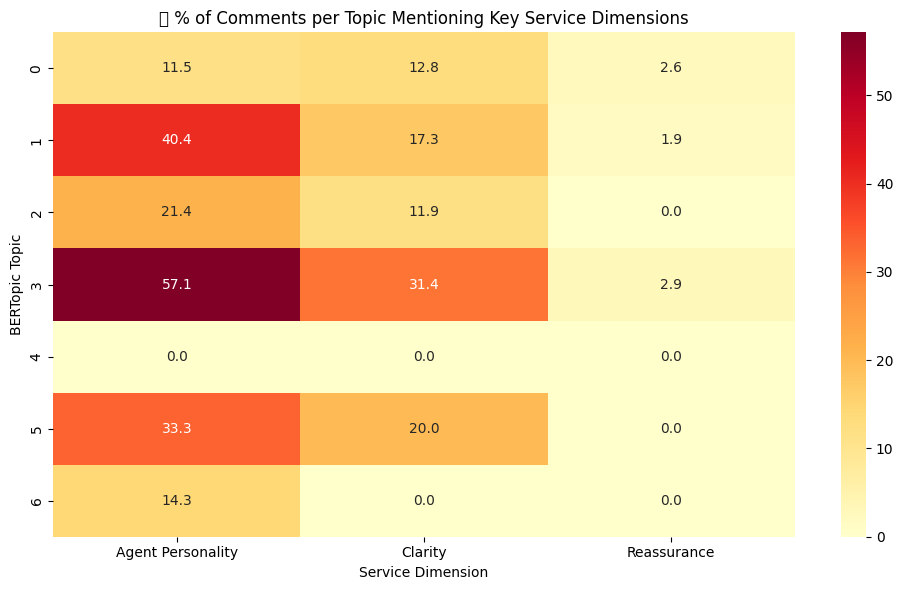

In [ ]:

def quantify_service_dimensions(df_with_topics, topic_model, text_column='LTR_COMMENT_TOPIC_M'):


    print("\n🔍 Setting up keyword dictionaries...")
    service_keywords = {
        "Agent Personality": ["friendly", "patient", "polite", "cheerful", "kind", "attitude", "courteous"],
        "Clarity": ["clear", "explained", "simple", "easy", "understand", "straightforward", "transparent"],
        "Reassurance": ["confident", "reassured", "helped", "support", "cared", "trusted", "secure"]
    }

    # Prep
    df_topics = df_with_topics.copy()
    df_topics = df_topics[df_topics['topic'] != -1]  # remove outliers

    # Normalize text
    df_topics['text_lower'] = df_topics[text_column].str.lower()

    # Flag mentions of each category
    for cat, keywords in service_keywords.items():
        df_topics[cat] = df_topics['text_lower'].apply(
            lambda x: any(word in x for word in keywords)
        )

    print("📊 Calculating percentages per topic...")

    # Group by topic and calculate proportions
    percentages = df_topics.groupby("topic")[
        list(service_keywords.keys())
    ].mean() * 100  # convert to %

    print(percentages.round(2))

    # Optional heatmap visualization
    plt.figure(figsize=(10, 6))
    sns.heatmap(percentages, annot=True, fmt=".1f", cmap="YlOrRd")
    plt.title("💬 % of Comments per Topic Mentioning Key Service Dimensions")
    plt.xlabel("Service Dimension")
    plt.ylabel("BERTopic Topic")
    plt.tight_layout()
    plt.show()

    return percentages


percentages = quantify_service_dimensions(df_clean, topic_model, text_column='LTR_COMMENT_TOPIC_M')

In [ ]:


def assign_themes_with_coverage(topic_info_df):

    # Define theme keyword rules
    theme_keywords = {
        "Communication Issues / Delays": ["problem", "cancel", "wait", "try","confuse","awful"],
        "Product & Performance": ["broadband", "wifi", "speed", "efficient", "contract", "connection"],
        "Clarity & Understanding": ["explain", "understand", "clarity", "clear"],
        "Agent Support": ["helpful", "friendly", "polite", "patient", "kind"],
        "Installation & Engineer Visit": ["install", "installation", "engineer", "box", "setup"],
        "Other / Mixed": []
    }

    theme_results = []
    top_theme_labels = []

    for _, row in topic_info_df.iterrows():
        rep_docs = " ".join(row.get("Representative_Docs", [])).lower()
        keywords_str = row['Name']
        keywords = [kw.strip().lower() for kw in keywords_str.split(",")]
        combined_text = " ".join(keywords) + " " + rep_docs

        # Count hits per theme
        match_counts = defaultdict(int)
        total_matches = 0

        for theme, words in theme_keywords.items():
            for w in words:
                count = combined_text.count(w)
                match_counts[theme] += count
                total_matches += count

        # Normalize to percentage
        theme_percent = {
            theme: round((count / total_matches) * 100, 1) if total_matches > 0 else 0
            for theme, count in match_counts.items()
        }

        # Pick top 1–2 themes
        sorted_themes = sorted(theme_percent.items(), key=lambda x: x[1], reverse=True)
        top_themes = [theme for theme, pct in sorted_themes if pct > 10]

        theme_results.append(theme_percent)
        top_theme_labels.append(", ".join(top_themes[:2]) if top_themes else "Other / Mixed")

    # Add to dataframe
    topic_info_df["Top Themes"] = top_theme_labels
    topic_info_df["Theme Coverage"] = theme_results

    return topic_info_df

topic_info_df = topic_model.get_topic_info()
topic_info_df = assign_themes_with_coverage(topic_info_df)

# Display with themes
display(topic_info_df[["Topic", "Name", "Top Themes", "Theme Coverage"]])


,Topic,Name,Top Themes,Theme Coverage
0,-1,-1_order_agent_deal_sort,"Installation & Engineer Visit, Product & Perfo...","{'Communication Issues / Delays': 11.8, 'Produ..."
1,0,0_phone_broadband_day_new,"Installation & Engineer Visit, Communication I...","{'Communication Issues / Delays': 28.6, 'Produ..."
2,1,1_communication_speak_talk_lady,Clarity & Understanding,"{'Communication Issues / Delays': 0.0, 'Produc..."
3,2,2_engineer_installation_come_install,"Installation & Engineer Visit, Agent Support","{'Communication Issues / Delays': 4.8, 'Produc..."
4,3,3_staff_explain_advisor_patient,"Agent Support, Clarity & Understanding","{'Communication Issues / Delays': 0.0, 'Produc..."
5,4,4_excellent_fantastic_great_amazing,Other / Mixed,"{'Communication Issues / Delays': 0, 'Product ..."
6,5,5_quick_quick efficient_efficient_coverage,"Product & Performance, Agent Support","{'Communication Issues / Delays': 0.0, 'Produc..."
7,6,6_price_reasonable price_reasonable_value,Other / Mixed,"{'Communication Issues / Delays': 0, 'Product ..."


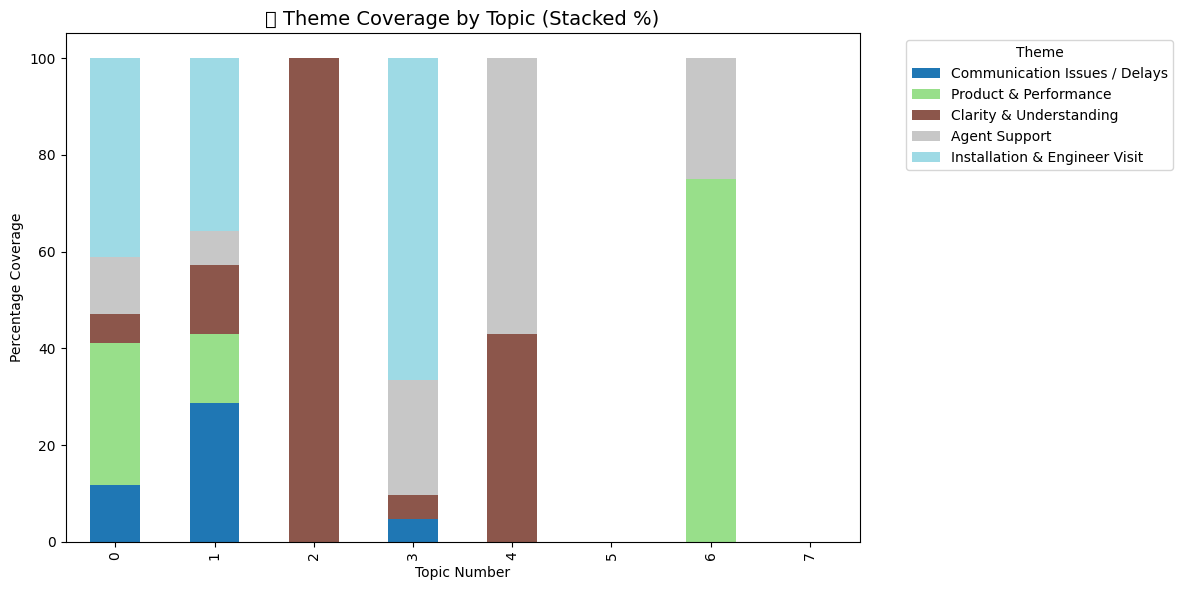

In [ ]:
def plot_theme_coverage_stacked(topic_info_df, top_n=10):

    # Create a matrix of shape (n_topics x n_themes)
    coverage_df = pd.DataFrame(topic_info_df["Theme Coverage"].tolist())

    # Filter top N topics if needed
    coverage_df = coverage_df.sort_index().head(top_n)

    # Plot
    ax = coverage_df.plot(
        kind="bar",
        stacked=True,
        figsize=(12, 6),
        colormap="tab20"
    )
    plt.title("🧠 Theme Coverage by Topic (Stacked %)", fontsize=14)
    plt.ylabel("Percentage Coverage")
    plt.xlabel("Topic Number")
    plt.legend(title="Theme", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

plot_theme_coverage_stacked(topic_info_df)


## **COMPARE TM**

In [ ]:
from sklearn.preprocessing import normalize

def plot_intertopic_distance_map(model, vectorizer, model_name="LDA", n_neighbors=15, min_dist=0.1):

    print(f"🔍 Generating intertopic distance map for {model_name}...")

    topic_word_matrix = model.components_
    topic_word_matrix = normalize(topic_word_matrix, norm='l1', axis=1)  # Normalize rows

    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric='cosine', random_state=42)
    embedding = reducer.fit_transform(topic_word_matrix)

    # Get top words per topic for labels
    feature_names = vectorizer.get_feature_names_out()
    labels = []
    for topic in model.components_:
        top_indices = topic.argsort()[-5:][::-1]
        top_terms = [feature_names[i] for i in top_indices]
        labels.append(", ".join(top_terms))

    # Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], s=200, marker='o')
    for i, (x, y) in enumerate(embedding):
        plt.text(x, y, f"T{i+1}: {labels[i]}", fontsize=9, ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", fc="lightyellow", alpha=0.6))
    plt.title(f"📍 Intertopic Distance Map ({model_name})")
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


🔍 Generating intertopic distance map for LDA...


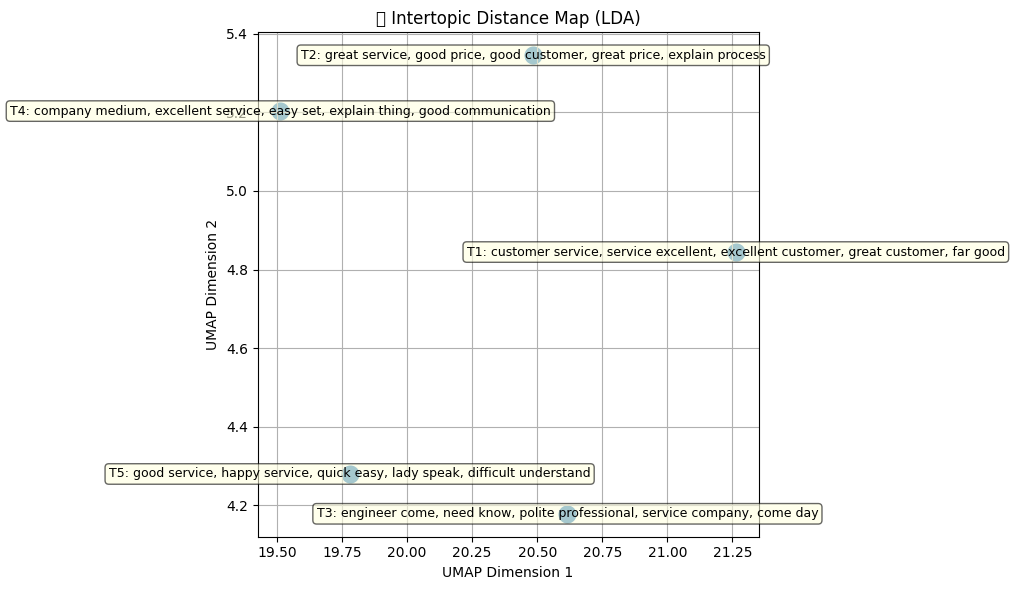

🔍 Generating intertopic distance map for NMF...


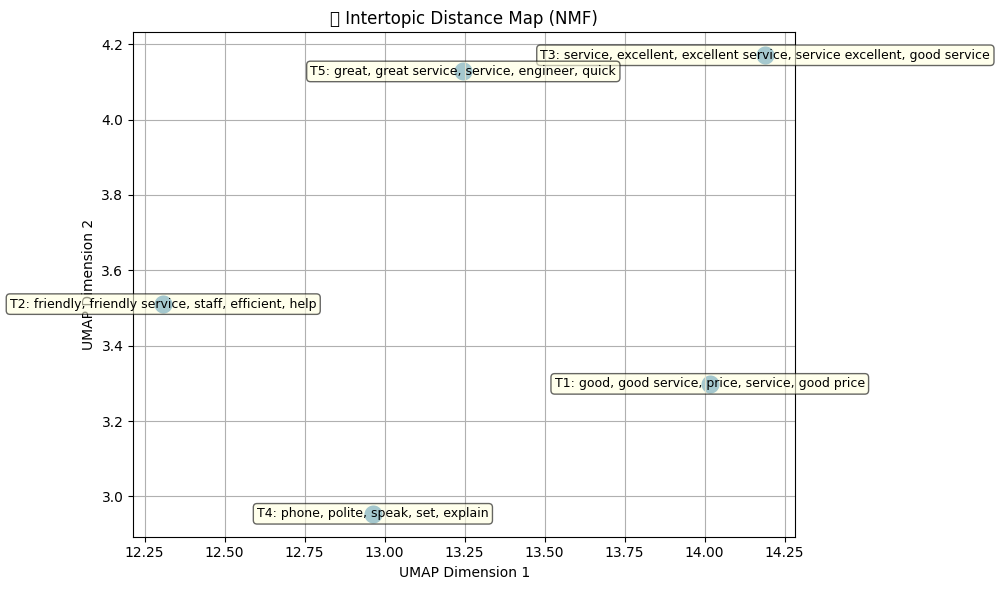

In [ ]:
# For LDA
plot_intertopic_distance_map(lda_model, vectorizer, model_name="LDA")

# For NMF
plot_intertopic_distance_map(nmf_model, tfidf_vectorizer, model_name="NMF")


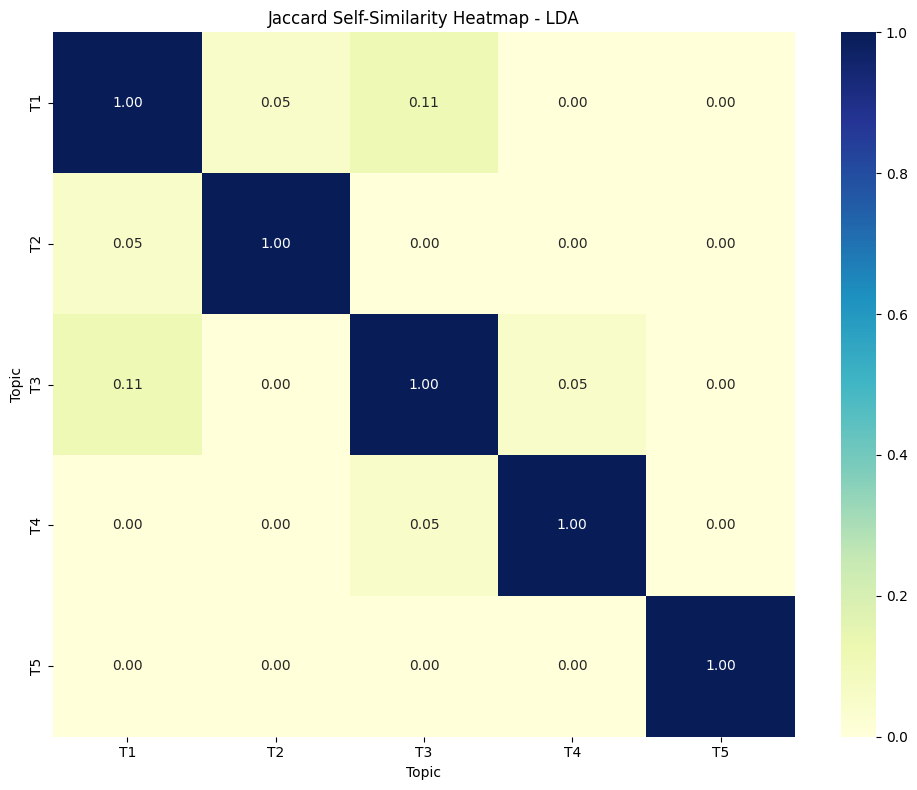

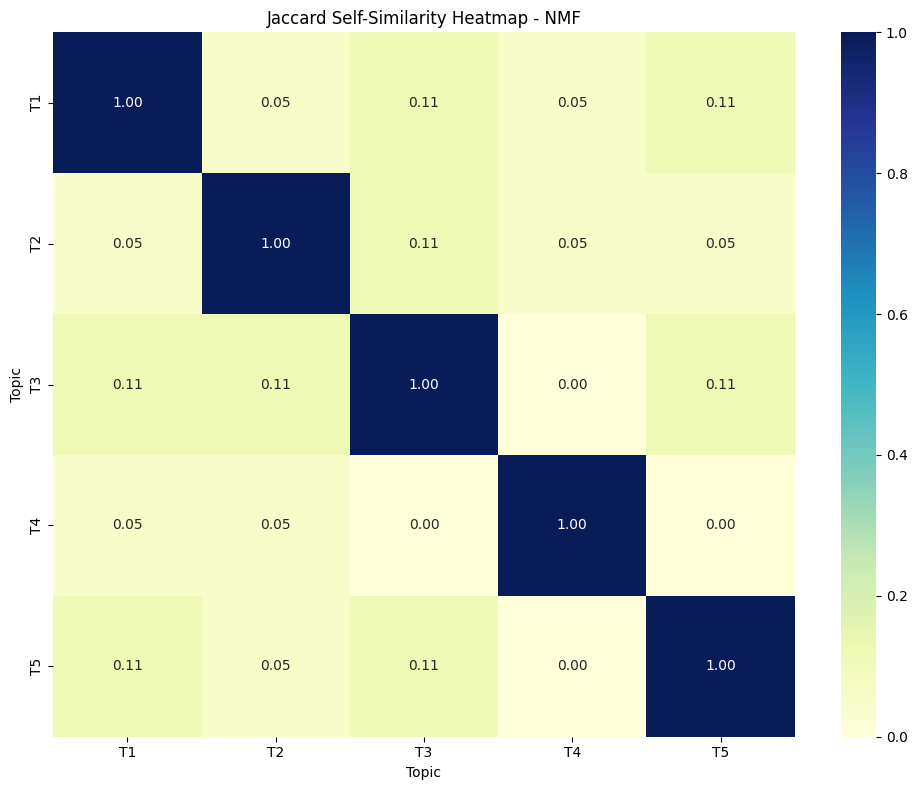

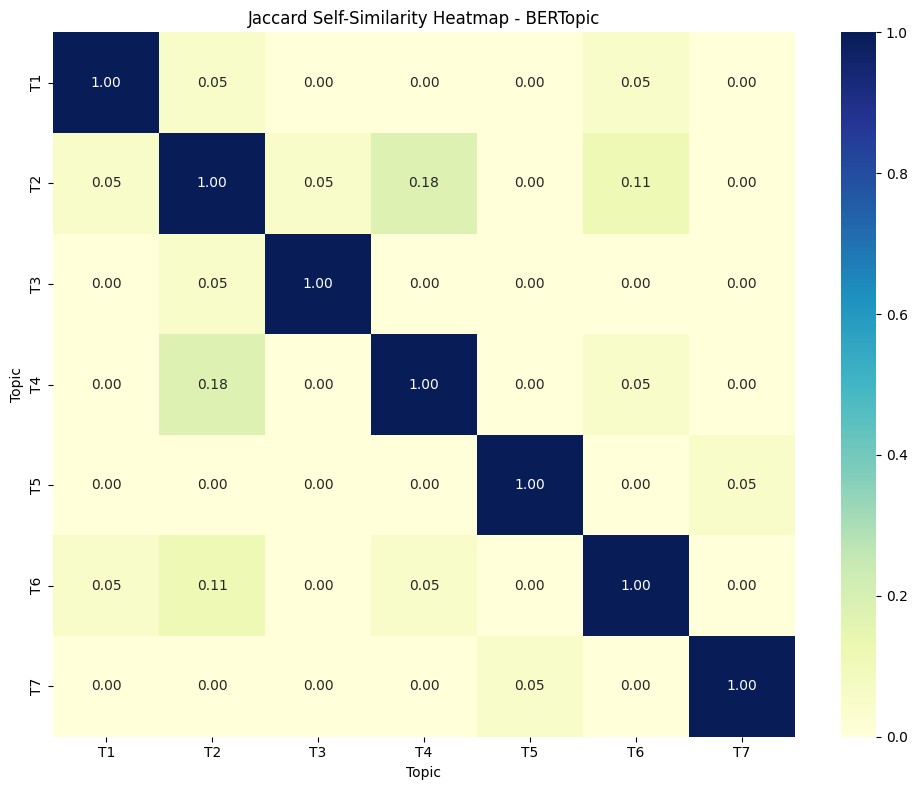

In [ ]:


def jaccard_self_similarity_heatmap(model, vectorizer=None, top_n=10, model_name="Model", title="Jaccard Self-Similarity Heatmap"):


    # Extract topic words based on model type
    topic_words = []

    # if hasattr(model, "get_topics"):  # BERTopic
    #     topics = model.get_topics()
    #     topic_words = [
    #         [word for word, _ in topics[i][:top_n]] for i in range(len(topics)) if topics[i]
    #     ]
    if hasattr(model, "get_topics"):  # BERTopic
        topics = model.get_topics()
        topic_words = [
            [word for word, _ in topics[i][:top_n]]
            for i in topics.keys()
            if i != -1 and topics[i]
          ]

    elif hasattr(model, "components_"):  # LDA or NMF
        feature_names = vectorizer.get_feature_names_out()
        for topic_weights in model.components_:
            top_indices = topic_weights.argsort()[::-1][:top_n]
            topic_words.append([feature_names[i] for i in top_indices])
    else:
        raise ValueError("Unsupported model type or missing vectorizer.")

    # Compute Jaccard self-similarity matrix
    topic_sets = [set(words) for words in topic_words]
    n_topics = len(topic_sets)
    similarity_matrix = np.zeros((n_topics, n_topics))

    for i in range(n_topics):
        for j in range(n_topics):
            if i == j:
                similarity_matrix[i, j] = 1.0
            else:
                inter = topic_sets[i] & topic_sets[j]
                union = topic_sets[i] | topic_sets[j]
                similarity_matrix[i, j] = len(inter) / len(union) if union else 0

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap="YlGnBu",
                xticklabels=[f"T{i+1}" for i in range(n_topics)],
                yticklabels=[f"T{i+1}" for i in range(n_topics)])
    plt.title(f"{title} - {model_name}")
    plt.xlabel("Topic")
    plt.ylabel("Topic")
    plt.tight_layout()
    plt.show()

# For LDA or NMF
jaccard_self_similarity_heatmap(lda_model, vectorizer=vectorizer, model_name="LDA")
jaccard_self_similarity_heatmap(nmf_model, vectorizer=tfidf_vectorizer, model_name="NMF")

# For BERTopic
jaccard_self_similarity_heatmap(topic_model, model_name="BERTopic")

## **TO DOS**

### ✅ **1. Preprocessing – Done**

You've:

* 🧹 **Filtered out February** responses ✅
* 🪪 **Segmented** data into the 4 groups:

  * `nonvolt_control`
  * `nonvolt_pilot`
  * `volt_control`
  * `volt_pilot`
* 🧼 Applied **text cleaning and lemmatization** ✅

---

### 📍 **Where You Are Now:**

You've done some **topic modeling (LDA/NMF/BERTopic)** and are trying to visualize **topic overlap and coherence**, both across and within models — this aligns with **Task 2** in your brief.

You also generated some plots like intertopic distance maps and Jaccard heatmaps, which is the **right path**.

---

## 🔜 What’s Next

Here’s a prioritized roadmap to complete the full brief:

---

### ✅ 2. **Topic Modeling & Theme Discovery (You're Midway)**

For each segment (General / VOLT):

#### You need to:

1. ✅ Identify top latent topics (you've mostly done this).
2. ❗ **Compare topic distributions** by treatment group.

   * Use **topic proportions per group** (e.g., what % of responses in `volt_pilot` mention Topic 2?).
   * **Stacked bar plots** or **heatmaps** will help.
3. ❗ **Quantify percentage of comments mentioning:**

   * Agent personality
   * Clarity
   * Reassurance
     → Use:
   * Manual keyword rules (`["friendly", "helpful", "understood"]`, etc.)
   * OR embed all responses and run **semantic search** with LLM/embeddings.
4. ✅ You’ve begun comparing topic overlap using Jaccard. Great for interpretability.

---

### 🔥 3. **Sentiment Analysis (Critical for Task 3)**

#### You need to:

1. ❗ **Assign sentiment** to each comment

   * Options: VADER, TextBlob, or better: **finetuned LLM sentiment model** or **Hugging Face transformers** (e.g., `cardiffnlp/twitter-roberta-base-sentiment`).
2. ❗ **Compare sentiment:**

   * Treatment vs Control
   * VOLT vs General
   * Use **boxplots, violin plots**, or **bar charts** (for % pos/neg/neutral).
3. ❗ **Topic–Sentiment Link**:

   * Group by topic and **average sentiment**
   * See which topics co-occur with strong/weak sentiment.
   * Use **bar chart of sentiment per topic**.
4. ❗ **Emotional tone shift**:

   * Use emotion lexicons (NRC, Empath) or models detecting **joy, sadness, anger** etc.
   * Compare **before/after script**.

---

### 🧠 4. **Modelling + Interpretation (Advanced Insight)**

#### Optional, but insightful:

1. **Train classifier** (e.g., logistic regression, random forest):

   * Predict `positive vs negative sentiment`
   * Features: topic presence, segment, script (treatment), metadata
2. **Evaluate feature importance** to identify:

   * What **drives positive sentiment**?
   * Does **treatment influence sentiment**, after controlling for segment?

---

### ✅ Visual + Reporting Tips

* Use **UMAP/PCA** plots for topic space (already started ✅)
* Use **Jaccard heatmaps** to show topic distinctiveness (done ✅)
* Use **stacked bar charts** for topic distributions across groups
* Use **sentiment boxplots** per group

---

### 🧩 Summary of What To Deliver

| Task                                     | Status         | Notes                                                |
| ---------------------------------------- | -------------- | ---------------------------------------------------- |
| Preprocessing & segmentation             | ✅ Done         | Good                                                 |
| Topic Modeling (LDA/BERTopic/NMF)        | 🟡 In progress | Good base, refine comparisons                        |
| Topic-Treatment comparison               | ❗To do         | Plot % of topic mentions by group                    |
| Agent traits keyword matching            | ❗To do         | Detect mentions of clarity, personality, reassurance |
| Sentiment Analysis                       | ❗To do         | Analyze, compare, and visualize                      |
| Topic-Sentiment correlation              | ❗To do         | Which topics are emotional                           |
| Emotional tone change                    | ❗To do         | Try NRC/Empath or LLM                                |
| Optional modeling (sentiment classifier) | ⬜ Optional     | But high value                                       |


## **SENTIMENT ANALYSIS**

In [ ]:
len(df_clean)

395

In [ ]:
# Load CardiffNLP sentiment model
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Function to assign sentiment
def get_sentiment_score(text):
    if not isinstance(text, str) or text.strip() == "":
        return np.nan, np.nan
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    probs = softmax(outputs.logits.detach().numpy()[0])
    label = np.argmax(probs)
    score = probs[label]
    label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
    return label_map[label], float(score)

# Apply to your DataFrame
print("🔍 Assigning sentiment...")
df_clean[["sentiment", "sentiment_conf"]] = df_clean["LTR_COMMENT_CLEAN"].apply(lambda x: pd.Series(get_sentiment_score(x)))


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


🔍 Assigning sentiment...


In [ ]:
# Filter only valid sentiment rows
df_sent = df_clean.dropna(subset=["sentiment"])
len(df_sent)

395

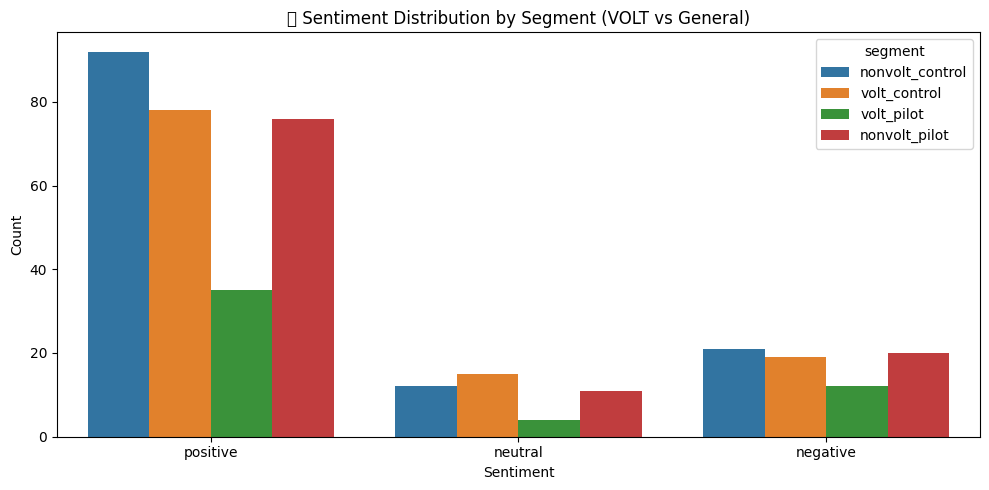

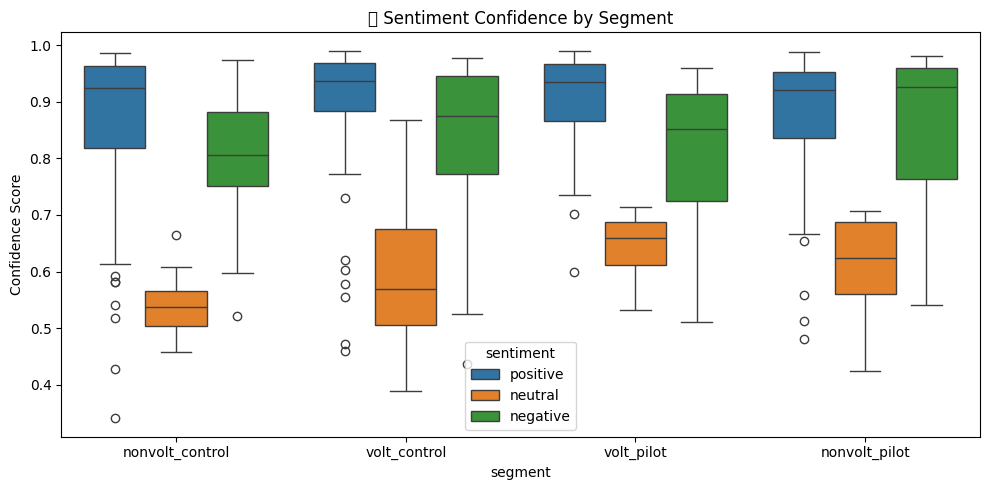

In [ ]:
# Bar plot: sentiment distribution by segment
plt.figure(figsize=(10, 5))
sns.countplot(data=df_sent, x="sentiment", hue="segment")
plt.title("🧭 Sentiment Distribution by Segment (VOLT vs General)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Boxplot: sentiment confidence score by segment
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_sent, x="segment", y="sentiment_conf", hue="sentiment")
plt.title("📦 Sentiment Confidence by Segment")
plt.ylabel("Confidence Score")
plt.tight_layout()
plt.show()


In [ ]:
df_sent['segment'].value_counts()

,count
segment,
nonvolt_control,125
volt_control,112
nonvolt_pilot,107
volt_pilot,51


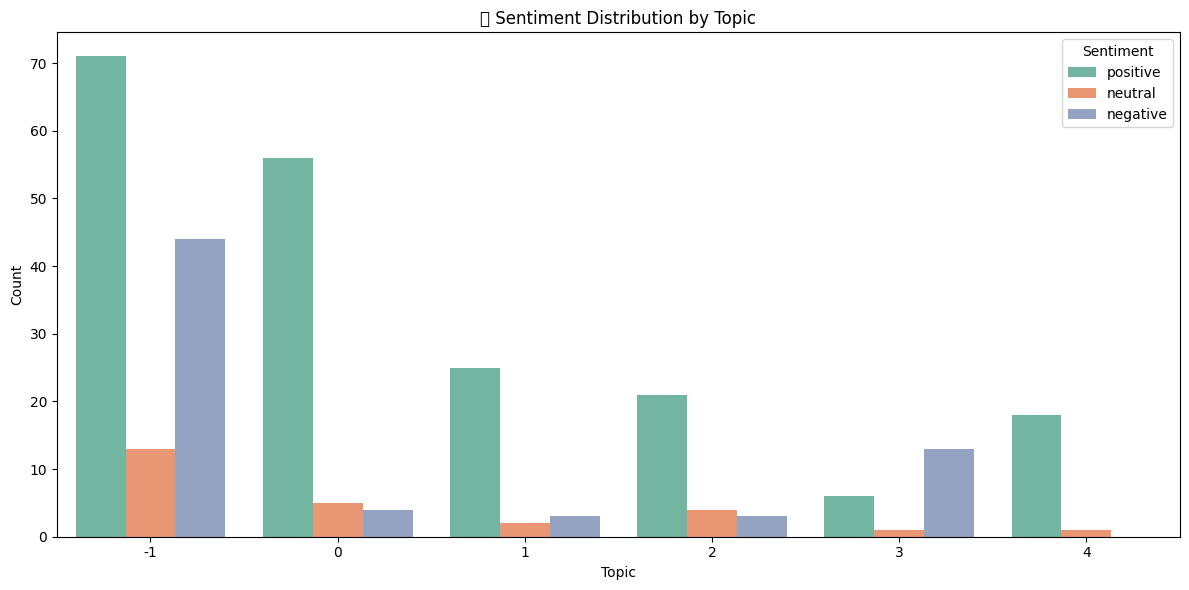

In [ ]:
# Countplot: Number of each sentiment label per topic
plt.figure(figsize=(12, 6))
sns.countplot(data=df_sent, x="topic", hue="sentiment", palette="Set2")
plt.title("📚 Sentiment Distribution by Topic")
plt.xlabel("Topic")
plt.ylabel("Count")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

In [ ]:
# - examples of positive and negative
# - what words specifically say positive or negative
# - shifts in emotional tone from control to pilot

In [ ]:
# Show 5 examples per sentiment
for sent in ["positive", "neutral", "negative"]:
    print(f"\n🔍 {sent.upper()} EXAMPLES:")
    examples = df_sent[df_sent["sentiment"] == sent]["LTR_COMMENT_CLEAN"].dropna().sample(5, random_state=42)
    for i, comment in enumerate(examples, 1):
        print(f"{i}. {comment}")



🔍 POSITIVE EXAMPLES:
1. guys who rang me was very pleasant and he explained exactly what he was going to be doing as i wasnt at home at the time.
2. great service and sales consultant..great deal offered
3. the customer service for a new customer was excellent.
4. price better than sky better broadband speed easy transition agent was a great sales assistant . instalation date quick. happy with service. looking forward to my company package.
5. very helpful and friendly advisor. good package deal.

🔍 NEUTRAL EXAMPLES:
1. polite knowledgeable call staff. explained everything really .
2. i have found that the service so far has been very good. however in my research once services are in the evaluation of company customer service responding to issues is quite poor. this worries me so will reserve judgement.
3. price of my bundle went up 2 days after i placed the order
4. because we were introduced back to companyhaving been with you before by a friend but couldnt find out about the offer 

In [ ]:

from scipy.special import loggamma

# Prepare vectorizer
vectorizer = CountVectorizer(stop_words="english", max_features=5000)
X = vectorizer.fit_transform(df_sent["LTR_COMMENT_CLEAN"])
words = np.array(vectorizer.get_feature_names_out())

# Create document-term matrix per sentiment
def get_word_counts_by_label(X, y, label):
    return np.asarray(X[y == label].sum(axis=0)).flatten()

labels = ["positive", "neutral", "negative"]
word_counts = {label: get_word_counts_by_label(X, df_sent["sentiment"], label) for label in labels}

# Prior: aggregated corpus
prior = sum(word_counts.values())
alpha = 0.01  # smoothing

# Function to compute log-odds ratio with informative Dirichlet prior
def log_odds_ratio(label, top_n=20):
    counts = word_counts[label]
    other_counts = sum(v for k, v in word_counts.items() if k != label)

    # Apply prior smoothing
    log_odds = np.log((counts + alpha) / (prior + alpha)) - np.log((other_counts + alpha) / (prior + alpha))

    # Get top N
    top_idx = np.argsort(log_odds)[::-1][:top_n]
    return list(zip(words[top_idx], log_odds[top_idx]))

# Show top unique words per sentiment
print("\n🟢 Unique Positive Words (Log-Odds):")
print(log_odds_ratio("positive", 15))

print("\n🔴 Unique Negative Words (Log-Odds):")
print(log_odds_ratio("negative", 15))

print("\n🟡 Unique Neutral Words (Log-Odds):")
print(log_odds_ratio("neutral", 15))



🟢 Unique Positive Words (Log-Odds):
[('excellent', 7.3783837129967145), ('efficient', 7.244941546337007), ('thank', 7.170888478512505), ('best', 7.00397413672268), ('patient', 6.68586094706836), ('contact', 6.55250788703459), ('understanding', 6.398594934535208), ('guy', 6.398594934535208), ('dealt', 6.398594934535208), ('amazing', 6.2166061010848646), ('understood', 6.2166061010848646), ('lovely', 6.2166061010848646), ('start', 6.2166061010848646), ('wasnt', 6.2166061010848646), ('questions', 6.2166061010848646)]

🔴 Unique Negative Words (Log-Odds):
[('different', 7.00397413672268), ('cancel', 6.55250788703459), ('isnt', 6.2166061010848646), ('difficult', 6.2166061010848646), ('message', 6.2166061010848646), ('emails', 6.2166061010848646), ('wrong', 6.2166061010848646), ('calls', 5.993961427306569), ('messages', 5.993961427306569), ('cut', 5.993961427306569), ('disappointed', 5.993961427306569), ('asked', 5.993961427306569), ('amended', 5.707110264748875), ('mobile', 5.70711026474887

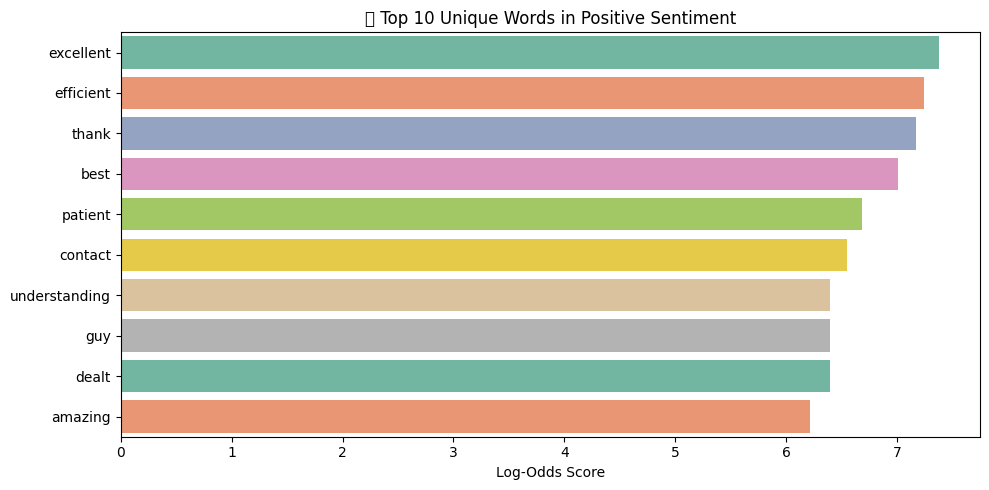

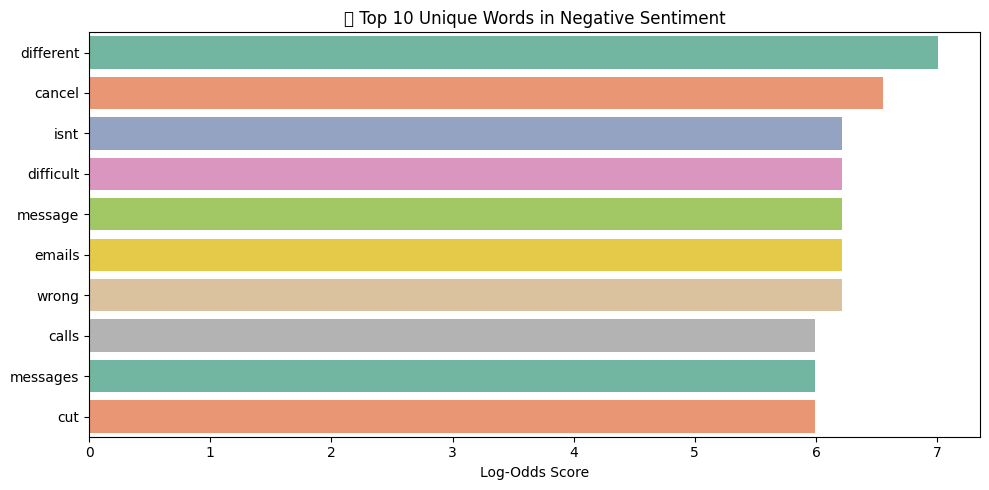

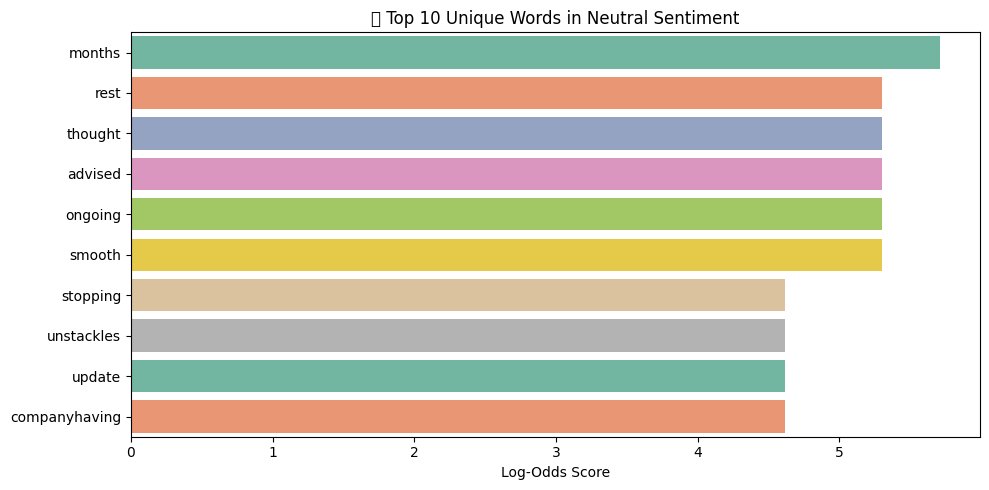

In [ ]:


def plot_top_unique_words(label, top_n=10):
    terms = log_odds_ratio(label, top_n)
    words_, scores_ = zip(*terms)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=scores_, y=words_, palette="Set2")
    plt.title(f"💡 Top {top_n} Unique Words in {label.title()} Sentiment")
    plt.xlabel("Log-Odds Score")
    plt.tight_layout()
    plt.show()

# Plot for each sentiment
plot_top_unique_words("positive")
plot_top_unique_words("negative")
plot_top_unique_words("neutral")


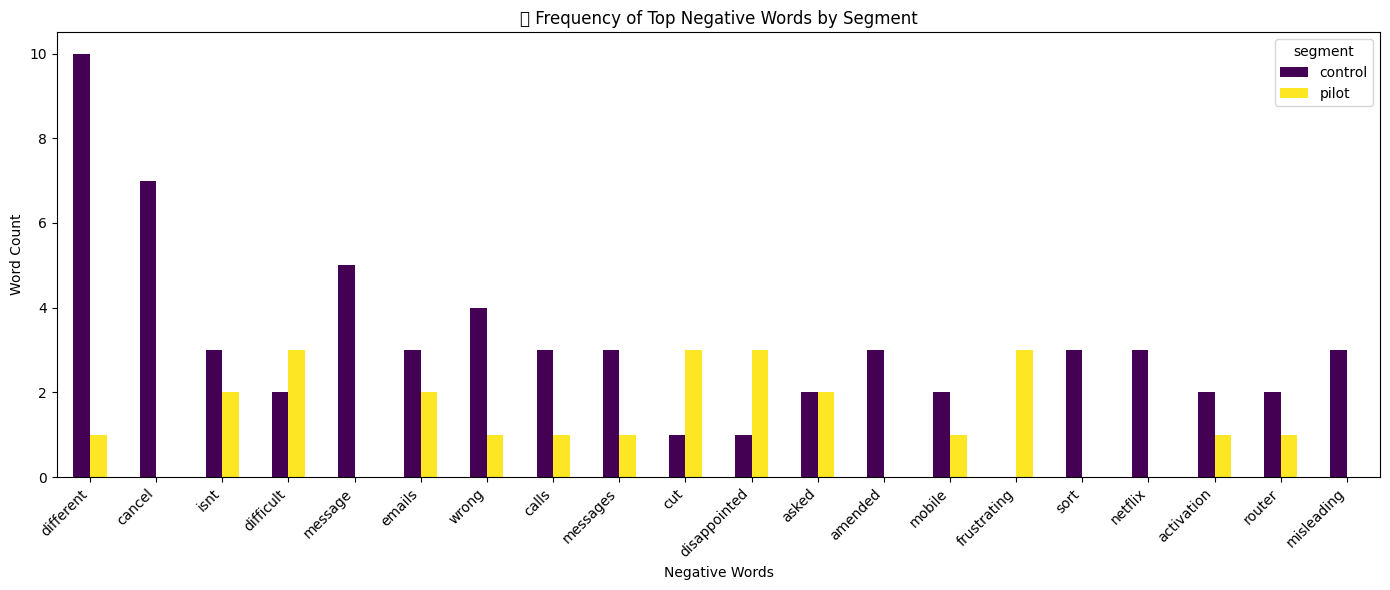

In [ ]:


# 1. Define your top distinctive negative words (you already have them)
top_neg_words = [word for word, _ in log_odds_ratio("negative", top_n=20)]  # or set manually

# 2. Use CountVectorizer restricted to those negative words
neg_vectorizer = CountVectorizer(vocabulary=top_neg_words)
X_neg = neg_vectorizer.fit_transform(df_sent["LTR_COMMENT_CLEAN"].fillna(""))

# 3. Create DataFrame of word counts
neg_word_df = pd.DataFrame(X_neg.toarray(), columns=neg_vectorizer.get_feature_names_out())
neg_word_df["segment"] = df_sent["COLUMN_4"].values

# 4. Group by segment and sum
segment_word_freq = neg_word_df.groupby("segment").sum().T

# 5. Plot: Word frequency across segments (grouped bar chart)

segment_word_freq.plot(kind="bar", figsize=(14, 6), colormap="viridis")
plt.title("🔴 Frequency of Top Negative Words by Segment")
plt.ylabel("Word Count")
plt.xlabel("Negative Words")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



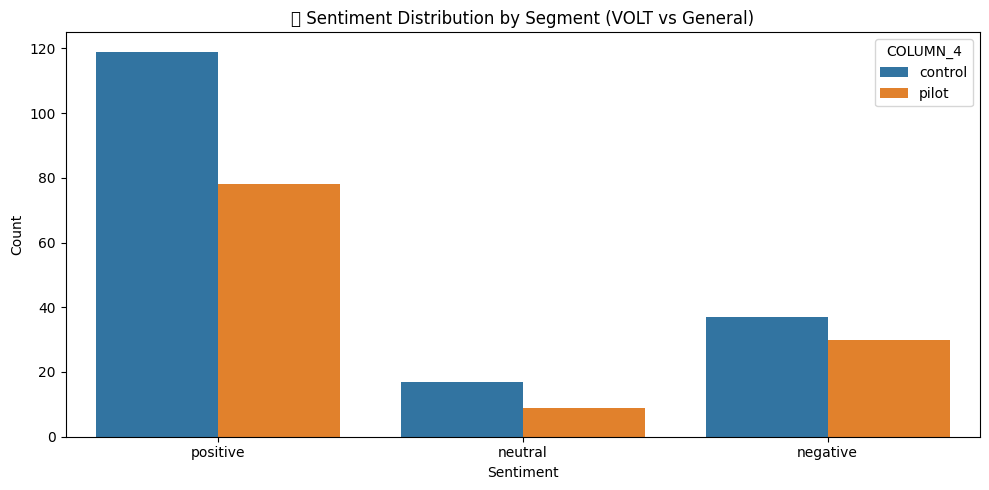

In [ ]:
# Bar plot: sentiment distribution by segment
plt.figure(figsize=(10, 5))
sns.countplot(data=df_sent, x="sentiment", hue="COLUMN_4")
plt.title("🧭 Sentiment Distribution by Segment (VOLT vs General)")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

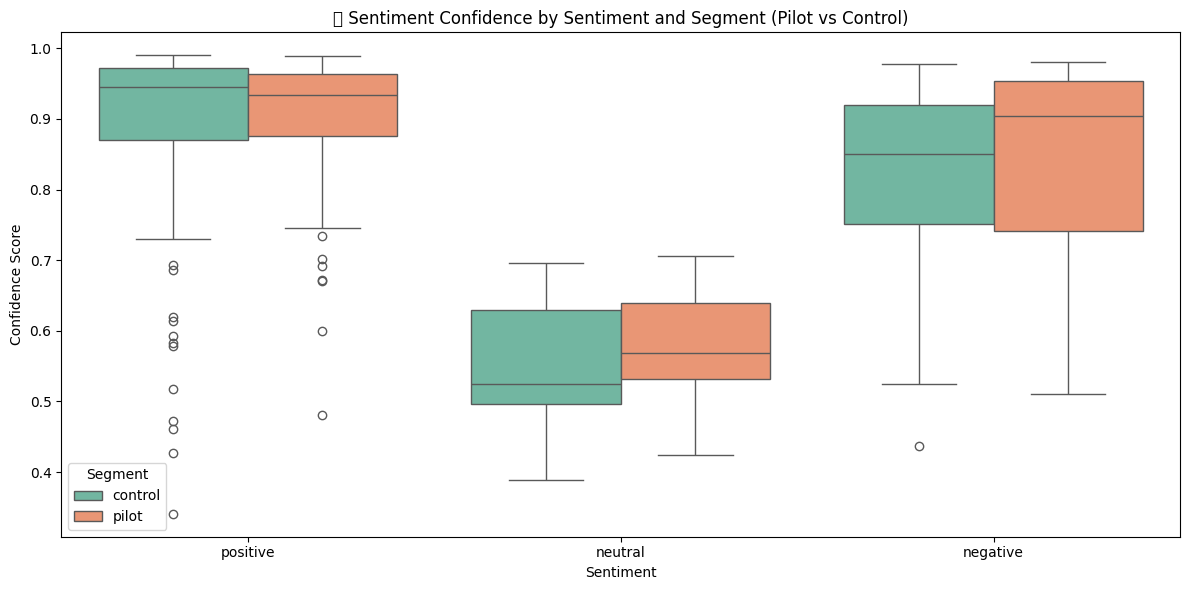

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_sent, x="sentiment", y="sentiment_conf", hue="COLUMN_4", palette="Set2")
plt.title("📦 Sentiment Confidence by Sentiment and Segment (Pilot vs Control)")
plt.xlabel("Sentiment")
plt.ylabel("Confidence Score")
plt.legend(title="Segment")
plt.tight_layout()
plt.show()


## **EMOTION SHIFT**

In [ ]:
nltk.download('averaged_perceptron_tagger')
from textblob import download_corpora



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Function to get dominant emotions per comment
def extract_emotions(text):
    if not isinstance(text, str) or text.strip() == "":
        return {}
    emo = NRCLex(text)
    return dict(Counter(emo.raw_emotion_scores))

# Apply to DataFrame
print("🔍 Extracting emotions...")
df_emotions = df_sent.copy()
df_emotions["emotion_counts"] = df_emotions["LTR_COMMENT_CLEAN"].apply(extract_emotions)


🔍 Extracting emotions...


In [ ]:
df_emotions["emotion_counts"].value_counts()

,count
emotion_counts,
{},43
"{'joy': 1, 'positive': 1, 'trust': 1}",25
"{'anticipation': 1, 'joy': 1, 'positive': 1, 'surprise': 1, 'trust': 1}",24
"{'joy': 1, 'positive': 1, 'trust': 1, 'anticipation': 1}",21
{'positive': 1},17
...,...
"{'fear': 1, 'negative': 6, 'sadness': 1, 'anger': 1, 'surprise': 2, 'anticipation': 2, 'joy': 1, 'positive': 2, 'trust': 2}",1
"{'trust': 2, 'anticipation': 3, 'positive': 4, 'negative': 1, 'sadness': 1}",1
"{'disgust': 1, 'negative': 1}",1


<Figure size 1200x600 with 0 Axes>

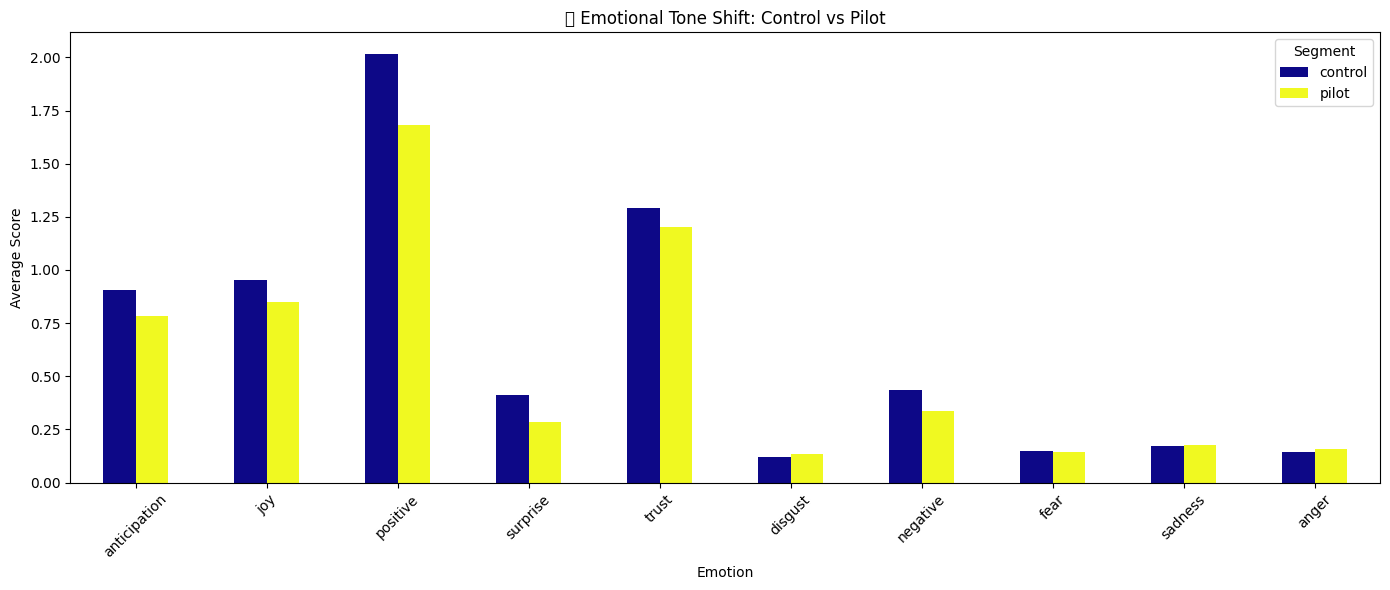

In [ ]:
# Step 3: Convert dictionary of emotions into separate columns
emotion_df = df_emotions["emotion_counts"].apply(pd.Series).fillna(0)
emotion_df["segment"] = df_emotions["COLUMN_4"]  # Use your actual segment column here

# Step 4: Average emotion scores per segment (control vs pilot)
avg_emotions_by_segment = emotion_df.groupby("segment").mean().T

# Step 5: Plotting emotional shift
plt.figure(figsize=(12, 6))
avg_emotions_by_segment.plot(kind='bar', figsize=(14, 6), colormap="plasma")
plt.title("🔄 Emotional Tone Shift: Control vs Pilot")
plt.xlabel("Emotion")
plt.ylabel("Average Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title="Segment")
plt.show()

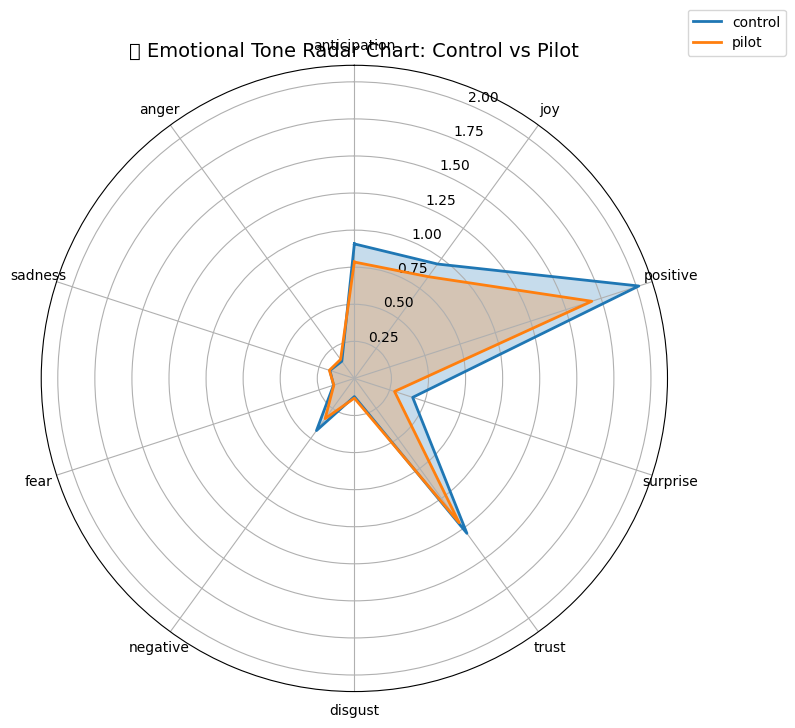

In [ ]:

# Ensure we have Control and Pilot average emotion scores
data = avg_emotions_by_segment.copy()
labels = data.index.tolist()  # Emotion labels

# Extract Control and Pilot scores
segments = data.columns.tolist()
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # close the circle

# Prepare figure
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Radar chart for each segment
for segment in segments:
    values = data[segment].tolist()
    values += values[:1]  # repeat first value to close loop
    ax.plot(angles, values, label=segment, linewidth=2)
    ax.fill(angles, values, alpha=0.25)

# Add emotion labels
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)

# Styling
plt.title("🕸️ Emotional Tone Radar Chart: Control vs Pilot", size=14)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()




| Emotion                   | Shift (Control → Pilot) | Interpretation                        |
| ------------------------- | ----------------------- | ------------------------------------- |
| **Positive**              | ↓ Slight drop           | Less positivity in pilot              |
| **Trust**                 | ↓ Slightly lower        | Trust has dipped slightly             |
| **Anticipation**          | ↓                       | Less anticipation or eagerness        |
| **Fear**                  | ↓ Lower in pilot        | Potentially fewer complaints/anxiety  |
| **Negative**              | \~ Similar              | No large shift in negativity overall  |
| **Sadness/Disgust/Anger** | \~ Flat                 | Stable emotional undercurrents        |
| **Surprise**              | ↑ Slight rise           | Maybe more unexpected outcomes/events |

---

## **PARAMETERS AFFECT**

In [ ]:
df_sent.columns

Index(['COLUMN_4', 'VOLT_FLAG', 'SURVEY_ID', 'SCORE', 'LTR_COMMENT',
       'PRIMARY_REASON', 'TO_CHAR', 'CONNECTION_TIME', 'SALES_PERSON_SAT',
       'SALES_FRIENDLY_SAT', 'COMMINICATION_SAT', 'FIRST_BILL_SAT',
       'AGENT_KNOWLEDGE', 'segment', 'LTR_COMMENT_CLEAN',
       'LTR_COMMENT_TOPIC_M', 'topic', 'sentiment', 'sentiment_conf'],
      dtype='object')

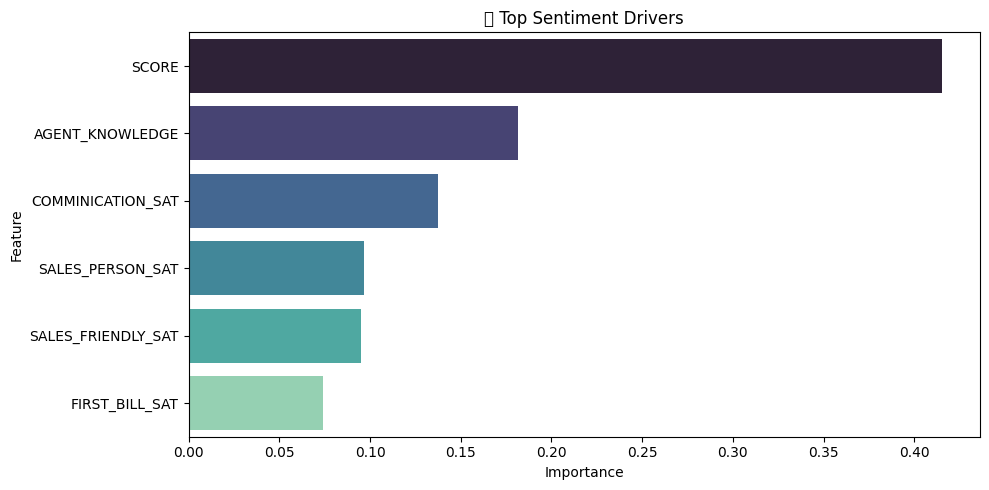

              Feature  Importance
0               SCORE    0.415423
5     AGENT_KNOWLEDGE    0.181491
3   COMMINICATION_SAT    0.137364
1    SALES_PERSON_SAT    0.096625
2  SALES_FRIENDLY_SAT    0.095039
4      FIRST_BILL_SAT    0.074058


In [ ]:

def find_key_sentiment_drivers(df, sentiment_col='sentiment', feature_cols=None, top_n=10, plot=True):
    # Default: Use satisfaction-related columns if not specified
    if feature_cols is None:
        feature_cols = [
            'SCORE', 'SALES_PERSON_SAT', 'SALES_FRIENDLY_SAT',
            'COMMINICATION_SAT', 'FIRST_BILL_SAT', 'AGENT_KNOWLEDGE'
        ]

    # Drop rows with missing sentiment or features
    df_model = df.dropna(subset=[sentiment_col] + feature_cols).copy()

    # Encode sentiment labels to numbers
    le = LabelEncoder()
    df_model['sentiment_encoded'] = le.fit_transform(df_model[sentiment_col])

    # Prepare data
    X = df_model[feature_cols]
    y = df_model['sentiment_encoded']

    # Train a random forest classifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)

    # Feature importances
    importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    if plot:
        plt.figure(figsize=(10, 5))
        sns.barplot(data=feature_importance_df.head(top_n), x='Importance', y='Feature', palette='mako')
        plt.title("📊 Top Sentiment Drivers")
        plt.tight_layout()
        plt.show()

    return feature_importance_df
drivers = find_key_sentiment_drivers(df_clean)
print(drivers)

